# Import

In [2]:
#Untuk Explore dan Preprocessing Data
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import external
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Untuk Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

#Untuk Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#Untuk Evaluasi Model
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, RocCurveDisplay

#Untuk Interpretasi Model
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.inspection import PartialDependenceDisplay

# Module XGBoost Approximator

## Utils

In [3]:
"""
This module contains several functions that are used in various stages of the process
"""
import numpy as np
from sklearn.metrics import roc_curve, auc
import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import random

RANDOM_SEED = 1

def softmax(x):
    """
    This function is useful for converting the aggregated results come from the different trees into class probabilities
    :param x: Numpy k-dimensional array
    :return: Softmax of X
    """
    return np.array([np.exp(x)/np.sum(np.exp(x))])

def get_auc(test_y,y_score):
    """

    :param test_y: Labels
    :param y_score: probabilities of labels
    :return: ROC AUC score
    """
    np.random.seed(RANDOM_SEED)
    classes=[i for i in range(y_score.shape[1])]
    y_test_binarize=np.array([[1 if i ==c else 0 for c in classes] for i in test_y])
    fpr, tpr, _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
    return auc(fpr, tpr)

def train_decision_tree(train,feature_cols,label_col):
    """
    This function gets a dataframe as an input and optimizes a decision tree to the data

    :param train: Pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :return: Trained sklearn decision tree
    """
    np.random.seed(RANDOM_SEED)
    parameters = {'criterion': ['entropy', 'gini'],
                  'max_depth': [3, 5, 10, 20, 50],
                  'min_samples_leaf': [1, 2, 5, 10]}
    model = DecisionTreeClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_



def train_rf_model(train,feature_cols,label_col):
    """
        This function gets a dataframe as an input and optimizes a random forest classifier to the data

        :param train: Pandas dataframe
        :param feature_cols: feature column names
        :param label_col: label column name
        :return: Trained random forest classifier
        """
    np.random.seed(RANDOM_SEED)
    parameters = {'n_estimators':[50,100],
                  'criterion': ['entropy'],
                  'min_samples_leaf': [1, 10, 100],
                  'max_features':['auto','log2']}
    model = RandomForestClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_

def train_xgb_classifier(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    np.random.seed(RANDOM_SEED)
    tuning_params = {'colsample_bytree': [0.3,0.5,0.9],
                  'learning_rate': [0.01,0.1],
                  'max_depth': [2,5,10],
                  'alpha': [1,10],
                     'n_estimators':[50,100]}
    if train[label_col].nunique() > 2:
        xgb_params['objective'] = "multi:softprob"
    else:
        xgb_params['objective'] = "binary:logitraw"
    model = xg.XGBClassifier(xgb_params)
    clfGS = GridSearchCV(model, tuning_params, cv=3)
    clfGS.fit(train[feature_cols], train[label_col])
    return clfGS.best_estimator_

def decision_tree_instance_depth(inst, dt):
    """

    :param inst: Instance to be inferenced - numpy vector
    :param dt: sklearn decision tree
    :return: The depth of the leaf that corresponds the instance
    """
    indx = 0
    depth = 0
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    epsilon = 0.0000001
    t = dt.tree_
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return  depth

def decision_tree_depths(test,feature_cols,dt):
    """
    This function is used for calculatingg the prediction depths of each instance that were inferenced by the input
    decision tree

    :param test: Pandas dataframe
    :param feature_cols: feature column names
    :param dt: decision tree
    :return: the depths of leaves that were assigned to each instance
    """
    X = test[feature_cols].values
    return [decision_tree_instance_depth(inst,dt) for inst in X]

#The following are not used:

def train_xgb_classifier2(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    if train[label_col].nunique() > 2:
        obj = "multi:softprob"
    else:
        obj = "binary:logitraw"
    xgb_model = xg.XGBClassifier(**xgb_params)
    xgb_model.fit(train[feature_cols], train[label_col])
    return  xgb_model

def ensemble_prediction_depth(X, rf):
    depths = []
    for inst in X:
        depths.append(np.sum([tree_prediction_depth(inst,base_model.tree_) for base_model in rf.estimators_]))
    return depths

def tree_prediction_depth(inst, t):
    indx = 0
    depth = 0
    epsilon = 0.0000001
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return depth

def get_features_statistics(data):
    min_values = {col:min(data[col]) for col in data.columns}
    max_values = {col: max(data[col]) for col in data.columns}
    mean_values = {col: np.mean(data[col]) for col in data.columns}
    return min_values, max_values, mean_values

## Conjunction

In [4]:
"""
This module contains the conjunction class

"""
import numpy as np

class Conjunction():
    """
    A conjunction is a combination of feature bounds mapped into a class probability vector
    """
    def __init__(self,feature_names,label_names,leaf_index=None,label_probas=None):
        """
        :param feature_names: list of strings. Also determine the dimensionality
        :param label_names: list of labels. Determines the number of labels too
        :param leaf_index: This feature is optional. Can be relevant if we'd like to document the leaves that were used from the input forest
        :param label_probas: also optional. Relevant if we'd like to determine the class probabilities within the constructor
        """
        self.feature_names = feature_names
        self.number_of_features = len(feature_names)
        self.label_names = label_names

        # upper and lower bounds of the feature for each rule
        self.features_upper = [np.inf] * len(feature_names)
        self.features_lower = [-np.inf] * len(feature_names)

        self.label_probas = np.array(label_probas)
        self.leaf_index = leaf_index

        #The following dict is used for excluding irrelevant merges of different dummy variables that come from the same categorical feature
        self.categorical_features_dict={}

    def addCondition(self, feature, threshold, bound):
        """
        This method adds a condition to the conjunction if relevant (rule isn't already contained in the conjunction)

        :param feature: relevant feature
        :param threshold: upper\lower bound
        :param bound: bound direction

        """
        #Check if the rule isn't already contained in the conjunction
        if bound == 'lower':
            if self.features_lower[feature] < threshold:
                self.features_lower[feature] = threshold
        else:
            if self.features_upper[feature] > threshold:
                self.features_upper[feature] = threshold

        #Address categorical features:
        if '=' in self.feature_names[feature] and threshold >= 1 and bound == 'lower':
            splitted = self.feature_names[feature].split('=')
            self.categorical_features_dict[splitted[0]] = splitted[1]

    def isContradict(self, other_conjunction):
        """
        :param other_conjunction: conjunction object
        :return: True if other and self have at least one contradiction, otherwise False
        """

        #Check upper and lower bounds contradiction
        for i in range(self.number_of_features):
            if self.features_upper[i] <= other_conjunction.features_lower[i] or self.features_lower[i] >=  other_conjunction.features_upper[i]:
                return True

        # check for categorical features contradiction
        for feature in self.feature_names:
            if feature in self.categorical_features_dict and feature in other_conjunction.categorical_features_dict:
                if self.categorical_features_dict[feature] != other_conjunction.categorical_features_dict[feature]:
                    return True

    def merge(self, other):
        """
        :param other: conjunction
        :return: new_conjunction - a merge of the self conjunction with other
        """
        new_conjunction = Conjunction(self.feature_names,self.label_names,
                                      self.leaf_index+other.leaf_index,self.label_probas+other.label_probas)
        new_conjunction.features_upper = [min(i,j) for i,j in zip(self.features_upper,other.features_upper)]
        new_conjunction.features_lower = [max(i, j) for i, j in zip(self.features_lower, other.features_lower)]
        new_conjunction.categorical_features_dict = self.categorical_features_dict
        new_conjunction.categorical_features_dict.update(other.categorical_features_dict)
        return new_conjunction

    def containsInstance(self,inst):
        """
        Checks whether the input instance falls under the conjunction

        :param inst:
        :return: True if
        """
        for i, lower, upper in zip(range(len(inst)), self.features_lower, self.features_upper):
            if inst[i] >= upper or inst[i] < lower:
                return False
        return True

    def has_low_interval(self,lowest_intervals):
        for lower,upper,interval in zip(self.features_lower,self.features_upper,lowest_intervals):
            if upper-lower<interval:
                return True
        return False

    def predict_probas(self):
        """
        :return: softmax of the result vector
        """

        return softmax(self.label_probas)

    def toString(self):
        """
        This function creates a string representation of the conjunction (only for demonstration purposes)
        """
        s = ""
        #save lower bounds
        for feature, threshold in enumerate(self.features_lower):
            if threshold != (-np.inf):
                s +=  self.feature_names[feature] + ' >= ' + str(np.round(threshold,3)) + ", "
        #save upper bounds
        for feature, threshold in enumerate(self.features_upper):
            if threshold != np.inf:
                s +=  self.feature_names[feature] + ' < ' + str(np.round(threshold,3)) + ", "
        #save labels
        s += 'labels: ['
        s+=str(self.label_probas)
        s += ']'
        return s

    #From here on everything is still tested
    def get_data_point(self, min_values, max_values, mean_values):
        X = []
        for i,feature in enumerate(self.feature_names):
            if self.features_lower[i]==-np.inf and self.features_upper[i]==np.inf:
                X.append(mean_values[feature])
            else:
                X.append(np.mean([max(min_values[feature],self.features_lower[i]), min(max_values[feature],self.features_upper[i])]))
        return np.array(X)

## Tree

In [5]:
"""
This module contain a tree class and several functions that are used for constructing the decision tree (stage 2 of the FBT algorithm)
"""

from scipy.stats import entropy

class Tree():
    """
    A decision tree that is based on hierarchical ordering of conjunction set

    Essentialy, the tree is a node with 2 descendents in case of an internal node and a prediction vector if its a leaf
    """

    def __init__(self,conjunctions, splitting_values,max_depth):
        """
        :param conjunctions: A list of conjunctions
        :param splitting_values: A dictionary in ehich keys are features and values are splitting values ordered by frequency
        :param max_depth: Tree maximum depth
        """

        self.conjunctions = conjunctions
        self.splitting_values = splitting_values
        self.max_depth = max_depth

    def split(self):
        # 1. Spliting is stopped if:
        #    a. there's a single conjunctions
        #    b. Entropy doesn't improved
        # 2. Splitting values - at each iteration we selrct the most common value for each feature and selects
        #    The one with the highest information gain
        # 3. Information gain is calculated as the mean emtropy across the different feature dimensions
        if len(self.conjunctions) == 1 or self.max_depth == 0:
            self.selected_feature = None
            self.left = None
            self.right = None
            return
        if len(set([np.argmax(conj.label_probas) for conj in self.conjunctions])) > 1:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_entropy(self.conjunctions, self.splitting_values)
        else:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_max_splitting(self.conjunctions,
                                                                                 self.splitting_values)
        if self.selected_feature is None:
            return
        descending_splitting_values = {k:([i for i in v if i!=self.selected_value] if k == self.selected_feature else v) for k,v in self.splitting_values.items()}
        self.left = Tree(l_conjunctions,descending_splitting_values,max_depth = self.max_depth-1)
        self.right = Tree(r_conjunctions, descending_splitting_values,max_depth = self.max_depth-1)
        self.left.split()
        self.right.split()

    def print_tree(self, feature_cols, prefix='|'):
        print(prefix, end='')
        if self.selected_feature is None:
            # Calculate the mean of the probabilities
            probas = np.array([c.label_probas for c in self.conjunctions])
            mean_probas = probas.mean(axis=0)

            # Determine the class with the highest mean probability
            class_label = np.argmax(mean_probas)
            print('--- Class:', self.conjunctions[0].label_names[class_label])
            return
        print('--- ' + str(feature_cols[self.selected_feature]) + ' >= ' + str(self.selected_value))
        self.left.print_tree(feature_cols, prefix + '   |')
        print(prefix, end='')
        print('--- ' + str(feature_cols[self.selected_feature]) + ' < ' + str(self.selected_value))
        self.right.print_tree(feature_cols, prefix + '   |')


    def predict_instance_proba(self,inst):
        """
        Predicte class probabilities for a given instance

        :param inst: Numpy array. Each dimension is a feature
        :return: class probabilities

        This is a recursive method that routes the instance to its relevant leaf
        """
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]
        if inst[self.selected_feature] >= self.selected_value:
            return self.left.predict_instance_proba(inst)
        else:
            return self.right.predict_instance_proba(inst)

    def get_instance_decision_path(self, inst,result=[]):
        """

        :param inst: numpy array represents an instance to be inferenced
        :param result: a list where each item represents a node
        :return:
        """
        result=list(result)
        if self.selected_feature == None:
            result.append('labels: '+str(np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]))
            return result
        else:
            if inst[self.selected_feature] >= self.selected_value:
                result.append(str(self.selected_feature)+'>='+str(self.selected_value))
                return self.left.get_instance_decision_path(inst,result)
            else:
                result.append(str(self.selected_feature) + '<' + str(self.selected_value))
                return self.right.get_instance_decision_path(inst, result)

    def predict_proba(self,data):
        """
        Predicted class probabilities for each data instance

        :param data: pandas dataframe
        :return: numpy array with calss probabilities for each data instance
        """
        probas=[]
        for inst in data.values:
            probas.append(self.predict_instance_proba(inst))
        return np.array(probas)

    def get_decision_paths(self,data):
        """

        :param data: matrix of [numer_of_instances, number_of_features] dimensions
        :return: A list where each item corresponds to the decision path of one insance
        """
        paths = []
        for inst in data.values:
            paths.append(self.get_instance_decision_path(inst))
        return paths

    # The following methods are relevant for the experimental evaluation. Enable calculating the depth of leaves used for predictions
    def predict_proba_and_depth(self,data):
        probas = []
        depths = []
        for inst in data.values:
            proba, depth = self.predict_instance_proba_and_depth(inst)
            probas.append(proba)
            depths.append(depth)
        return np.array(probas),depths

    def predict_instance_proba_and_depth(self,inst):
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0], 0
        if inst[self.selected_feature] >= self.selected_value:
            probas, depth = self.left.predict_instance_proba_and_depth(inst)
            return probas, depth + 1
        else:
            probas, depth = self.right.predict_instance_proba_and_depth(inst)
            return probas, depth + 1


def select_splitting_feature_by_entropy(conjunctions, splitting_values):
    """
    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    best_entropy = get_entropy([c.label_probas for c in conjunctions])
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions,temp_entropy = calculate_entropy_for_split(conjunctions,feature, values[i])
            # We want to prevent a case where all the conjunctions are going to one of the descendent
            if temp_entropy < best_entropy and len(temp_l_conjunctions) < conjunctions_len and  len(temp_r_conjunctions) < conjunctions_len:
                best_entropy = temp_entropy
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions
    return selected_feature,selected_value,best_entropy, l_conjunctions, r_conjunctions

def select_splitting_feature_by_max_splitting(conjunctions,splitting_values):
    """

    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    #best_entropy = get_entropy([c.label_probas for c in conjunctions])
    best_value = len(conjunctions)
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions, temp_value = calculate_max_for_split(conjunctions, feature, values[i])
            if temp_value < best_value:
                best_value = temp_value
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions

    return selected_feature,selected_value,0, l_conjunctions, r_conjunctions

def calculate_entropy_for_split(conjunctions,feature,value):
    """
    Calculate the entropy of splitting the conjunctions according to the given feature vale

    :param conjunctions: List of conjunctions
    :param feature: splitting feature
    :param value: splitting value
    :return: conjunctions of left and right nodes, weighted entropy
    """
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, calculate_weighted_entropy(l_probas, r_probas)

def calculate_weighted_entropy(l_probas,r_probas):
    """

    :param l_probas: numpy array wehre each item is a probability vector
    :param r_probas: numpy array wehre each item is a probability vector
    :return: weighted entropy
    """
    l_entropy, r_entropy = get_entropy(l_probas), get_entropy(r_probas)
    l_size,r_size = len(l_probas),len(r_probas)
    overall_size = l_size+r_size
    return(l_size*l_entropy+r_size*r_entropy)/overall_size


def get_entropy(probas):
    """
    Calculate antropy of an array of class probability vectors
    :param probas: An array of class probability vectors
    :return: the average entropy of each class vector
    """
    values = np.array([np.argmax(x) for x in probas])
    values, counts = np.unique(values, return_counts=True)
    probas = counts / np.sum(counts)
    return entropy(probas)

def calculate_max_for_split(conjunctions,feature,value):
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, max(len(l_conjunctions),len(r_conjunctions))

## Pruning

In [6]:
"""
This module contain the Pruner function for pruning a decision forest
"""
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

class Pruner():
    """
    A static class that supports the pruning of a decision forest
    """
    def predict_probas_tree(self,conjunctions,X):
        """
        Predict probabilities for X using a tree, represented as a conjunction set

        :param conjunctions: A list of conjunctions
        :param X: numpy array of data instances
        :return: class probabilities for each instance of X
        """

        probas = []
        for inst in X:
            for conj in conjunctions:
                if conj.containsInstance(inst):
                    probas.append(conj.label_probas)
        return np.array(probas)
    def predict_probas(self,forest,X):
        """
        Predict probabilities of X, using a decision forest

        :param forest: A list of decision trees where each tree is a list of conjunctions
        :param X: Numpy array of data instances
        :return: List of class probabilities vector
        """
        predictions = []
        if isinstance(X, pd.DataFrame):
            X = X.values
        for t in forest:
            predictions.append(self.predict_probas_tree(t, X))
        return np.array([softmax(pred)[0] for pred in np.array(predictions).sum(axis=0)])

    def predict(self,forest,X):
        """
            Predict labels of X, using a decision forest

            :param forest: A list of decision trees where each tree is a list of conjunctions
            :param X: Numpy array of data instances
            :return: class vector
        """
        return np.argmax(self.predict_probas(forest,X),axis=1)

    def get_forest_auc(self,forest,X,Y):
        """
        Calculates predictions ROC AUC

        :param forest: A list of lists of conjunctions
        :param X: Numpy array of data instances
        :param Y: Label vector
        :return: ROC AUC
        """
        y_probas = self.predict_probas(forest,X)
        return get_auc(Y,y_probas)

    def forests_kappa_score(self,probas1,probas2):
        """
        Calculates Cohen's kappa of the predictions divided from two vectors of class probabilities

        :param probas1: list of class probabilities
        :param probas2: list of class probabilities
        :return: Cohen's kappa
        """

        predictions1 = np.array([np.argmax(i) for i in probas1])
        predictions2 = np.array([np.argmax(i) for i in probas1])
        return cohen_kappa_score(predictions1,predictions2)

    def kappa_based_pruning(self,forest,X,Y,min_forest_size=10):
        """
        This method conduct a kappa-based ensemble pruning.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble

        The algorithm contains the following stages:
        1. Add the tree with the highest AUC for X to the new (empty) forest
        2. At each iteration add the tree with the highest cohen's kappa in relation to the new forest
        3. Stop when the new forest AUC doesn't improve and minimum forest size was reached
        """

        selected_indexes = [np.argmax([self.get_forest_auc([t],X,Y) for t in forest])] #Include only the tree with the best AUC
        previous_auc = 0
        current_auc = get_auc(Y,self.predict_probas([forest[selected_indexes[0]]],X))
        new_forest = [forest[selected_indexes[0]]]
        while current_auc > previous_auc or len(new_forest) <= min_forest_size:
            kappas = [1 if i in selected_indexes else self.forests_kappa_score(new_forest,[t],X) for i,t in enumerate(forest)]
            new_index = np.argmin(kappas)
            if new_index in selected_indexes:
                break
            selected_indexes.append(new_index)
            previous_auc = current_auc
            new_forest.append(forest[new_index])
            current_auc = get_auc(Y,self.predict_probas(new_forest,X))
        return new_forest

    def max_auc_pruning(self, forest, X, Y, min_forest_size=10):
        """
        This method conduct an ensemble pruning using a greedy algorithm that maximizes the AUC on the given dataset.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble
        """
        X = X.values
        trees_predictions = {i: self.predict_probas_tree(forest[i],X) for i in range(len(forest))} #predictions are stored beforehand for efficiency purposes
        selected_indexes = [np.argmax([get_auc(Y,trees_predictions[i]) for i in trees_predictions])] #get the tree with the highest AUC for the given dataset
        previous_auc = 0
        best_auc = get_auc(Y,trees_predictions[selected_indexes[0]])
        while best_auc > previous_auc or len(selected_indexes) <= min_forest_size:
            previous_auc = best_auc
            best_index = None
            for i in range(len(forest)):
                if i in selected_indexes:
                    continue
                probas = np.array([trees_predictions[indx] for indx in selected_indexes + [i]]) #get the probas given by each tree, included the tested one
                probas = np.array([softmax(prob)[0] for prob in probas.sum(axis=0)]) #aggregate the predictions
                temp_auc = get_auc(Y,probas)
                if temp_auc > best_auc or best_index==None:
                    best_auc = temp_auc
                    best_index = i
            selected_indexes.append(best_index)
        print('Pruned forest training set AUC: '+str(best_auc))
        return [t for i,t in enumerate(forest) if i in selected_indexes]




## Tree Extraction

In [7]:
"""
This module contains functions for extracting information of individual trees from XGBoost
"""

import re
#internal node parser:
feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')

#leaf parser:
leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')

def extractNodesFromModel(model):
    """
    Extract decision trees from XGBoost.

    :param model: XGBoost model
    :param feature_dict: {feature_name: feature_index}
    :return: trees: List of trees where trees represented as lists of dictionaries. Each dictionary represents a node within the corresponding tree
    """
    trees= []
    for tree_string in model._Booster.get_dump():
        nodes = [feature_regex.search('t' + node).groupdict() if '[' in node else leaf_regex.search('t' +node).groupdict() for node in tree_string.split('\n')[:-1]]
        trees.append(nodes)
    return trees

def extractClassValue(tree,leaf_index,label_names,class_index):
    """
    This function takes a leaf index and convert the class logit into a probability

    :param tree: dictionary that represents a decision tree
    :param leaf_index: leaf index - integer
    :param label_names: list of strings - labels
    :param class_index: index of the addressed class
    :return: class probabilitis
    """
    pred = float(tree[leaf_index]['prediction'])
    if len(label_names)>2:
        return [pred if i == class_index else 0 for i in range(len(label_names))]
    else:
        p = 1 / (1 + np.exp(pred))
        return [p,1-p]
def extractConjunctionsFromTree(tree, tree_index,leaf_index, feature_dict, label_names, class_index):
    """
    Covert the leaves of a tree into a set of conjunctions

    :param tree: list of dictionaries where each dictionary represents a node within a tree
    :param leaf_index: index of the currently processed node
    :param feature_dict: {feature name: feature index} - for converting xgboost feature names to conjunction feature indices
    :param label_names: possible class values
    :param class_index: currently addressed class - since each model is basically a binary classification of tree of a single class it's impoertant to know the relevant class
    :return: A set of conjunctions
    """
    if 'prediction' in tree[leaf_index]:
        probas = extractClassValue(tree,leaf_index,label_names,class_index)
        return [Conjunction(list(feature_dict.keys()),label_names,
                            leaf_index=[str(tree_index)+'_'+str(leaf_index)],label_probas=probas)]
    l_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['left']),feature_dict,label_names,class_index)
    r_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['right']),feature_dict,label_names,class_index)
    for c in l_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'upper')
    for c in r_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'lower')
    return l_conjunctions + r_conjunctions

def merge_two_conjunction_sets(conj_list1,conj_list2):
    """
    Gets two conjunction sets and return a set that is a cartesian product of the two input sets

    :param conj_list1:
    :param conj_list2:
    :return:
    """
    new_conjunction_list=[]
    for c1 in conj_list1:
        for c2 in conj_list2:
            if not c1.isContradict(c2):
                new_conjunction_list.append(c1.merge(c2))
    return new_conjunction_list

def postProcessTrees(conjunction_sets, num_of_labels):
    """
    This function is used for integrating mulitple binary trees into a single tree of multiple labels

    :param conjunction_sets: list of lists of conjunctions
    :param num_of_labels: number of labels in the dataset that was used for training
    :return: new list of conjunctions
    """

    new_conj_list = []
    for i in range(0, len(conjunction_sets), num_of_labels):
        conj = conjunction_sets[i]
        for j in range(i + 1, i + num_of_labels):
            conj = merge_two_conjunction_sets(conj, conjunction_sets[j])
        new_conj_list.append(conj)
    return new_conj_list

def extractConjunctionSetsFromForest(model,unique_labels,features):
    """
    This function takes XGBoost model and returns a list of trees where each tree is represented as a list of conjunctions.
    Each of the tree conjunctions stands for a single decision path

    :param model: XGBoost model
    :param unique_labels: label names
    :param features: feature names
    :return: a list of conjunctions
    """

    trees = extractNodesFromModel(model)
    num_of_labels = len(unique_labels)
    feature_dict = {v:k for k,v in enumerate(features)}
    conjunction_sets = {}
    for i,t in enumerate(trees): #i stands for the corresponding class index
        indexed_tree = {int(v['node_index']): v for v in t}
        conjunction_sets[i] = extractConjunctionsFromTree(indexed_tree,i,0, feature_dict, unique_labels, i % num_of_labels)
    if num_of_labels > 2:
        return postProcessTrees(conjunction_sets,num_of_labels)
    else:
        return list(conjunction_sets.values())


## Conjunction Set

In [8]:
"""
This module contains the ConjunctionSet class
"""

from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter
from pyod.models.knn import KNN
from pyod.models.lof import LOF

class ConjunctionSet():
    """
    ConjunctionSet is a class that represents a set of conjunctions.

    This is the output of stage 1.
    Each conjunction at the given set represents a possible combination of leaves from the source decision forests.
    """

    def __init__(self, max_number_of_conjunctions=np.inf, filter_method='probability'):
        """
        :param max_number_of_conjunctions: Number of maximum allowed conjunctions at each iteration
        :param filter_method: The approach that will be takes for filtering conjunctions
        """
        self.filter_method = filter_method
        self.max_number_of_conjunctions = max_number_of_conjunctions

    def fit(self,trees_conjunctions,data,feature_cols,label_col, int_features = []):
        """

        :param trees_conjunctions: Decision forest given as a list of lists of conjunction objects.
        :param data: pandas dataframe that was used for training the decision forest
        :param feature_cols: Feature names in the dataframe
        :param label_col: label column name
        :param int_features: list of integer feartures
        :return: set a list of conjunction set that best represents the decision forest
        """
        self.feature_cols = feature_cols
        self.labels = data[label_col].unique()
        self.trees_conjunctions = trees_conjunctions
        self.int_features = int_features

        #Create an ECDF for each feature
        self.set_probability_ecdf(data)


        #Extract all the leaf combinations that were applied for training data:
        print('Create conjunction set from training data instances')
        self.create_conjunction_set_from_data(data)


        #set maximum number of conjunctions per label
        print('Create complete conjunction set')
        self.calculate_max_conjunctions_per_label(data,label_col)

        # Run the algorithm of creating the complete conjunction set:
        self.createConjunctionSetFromTreeConjunctions()

        #Merge the two conjunctions:
        self.conjunctions = self.conjunctions + self.training_conjunctions

        #Get the ordered splitting points for creating the hierarchy at stage 2
        self.set_ordered_splitting_points()

    def createConjunctionSetFromTreeConjunctions(self):
        """
        This method generates the conjunction set (stage 1) from the decision forest
        """
        self.conjunctions = self.trees_conjunctions[0] #Define the first tree as the current conjunction set
        i = 1
        self.size_per_iteration = [len(self.conjunctions)]
        while i < len(self.trees_conjunctions): #At each iteration we merge the next tree with the current conjunction set
            self.conjunctions= merge_two_conjunction_sets(self.conjunctions, self.trees_conjunctions[i])
            i+=1
            self.filter() #Filter redundant conjunction according to the filtering strategy
            self.size_per_iteration.append(len(self.conjunctions))
            print('Size at iteration '+str(i)+': '+str(len(self.conjunctions)))
    def filter(self):
        """
        This method filters the current conjunction set according to the filtering strategy.

        At the first stage it filters conjunctions that contain irrelevant integer rules.
        For example: If x is an integer then a conjunction that contains  5.5 >= x < 6 is filtered out
        """
        self.conjunctions = [conj for conj in self.conjunctions if self.int_filter(conj)]
        if len(self.conjunctions)<=self.max_number_of_conjunctions:
            return
        if self.filter_method == 'probability':
            self.filter_by_probability()
        if self.filter_method == 'probability_label':
            self.filter_by_probability_labels()
        elif self.filter_method == 'knn':
            self.filter_by_knn()
        elif self.filter_method == 'LOF':
            self.filter_by_lof()

    def filter_by_probability(self,EPSILON=0.00001):
        """
        This method filters conjunctions according to the product of each rule ECDF

        :param EPSILON: Prevent a case of probability = 0

        """
        independent_probs = []
        for conj in self.conjunctions:
            independent_probs.append(np.sum(np.log([self.ecdf[col](conj.features_upper[col])-self.ecdf[col](conj.features_lower[col])+EPSILON for
                                                         col in range(len(self.feature_cols))])))
        max_value = sorted(independent_probs, reverse=True)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c,val in zip(self.conjunctions,independent_probs) if val >= max_value] #It actually includes a little more than max_number_of conjunctions due to the >=

    def predict(self,X):
        return [np.argmax(i) for i in self.predict_proba(X)]

    def predict_proba(self,X):
        predictions = []
        if isinstance(X,pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            for conjunction in self.conjunctions:
                if conjunction.containsInstance(inst):
                    predictions.append(np.exp(conjunction.label_probas) / np.sum(np.exp(conjunction.label_probas), axis=0)) #softmax
                    break
        return np.array(predictions)

    #Filtering functions

    def set_probability_ecdf(self,data):
        self.ecdf = {i:ECDF(data[col].values) for i,col in enumerate(self.feature_cols)}

    def set_minimum_intervals(self,data):
        intervals = {col: data[col].diff().sort_values().dropna().values for col in self.feature_cols}
        self.minimum_intervals = [x[x > 0].min()*self.min_interval_ratio for col, x in intervals.items()]

    def int_filter(self,conj,EPSILLON=0.00001):
        for i,feature in enumerate(self.feature_cols):
            if feature in self.int_features:
                if conj.features_upper[i]-conj.features_lower[i]-EPSILLON <= 0.5 and (conj.features_lower[i] % 1) > 0:
                    return False
        return True

    def create_conjunction_set_from_data(self,X):
        """

        :param X: Pandas dataframe (or matrix)
        :return: training_conjunctions - all the conjunctions that were applied for X
        """
        participated_leaves = []
        self.training_conjunctions = []
        if isinstance(X, pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            s=''
            conj = Conjunction(self.feature_cols,self.labels,leaf_index=[],label_probas=np.zeros(len(self.labels))) #Define the conjunction
            for tree_index,tree in enumerate(self.trees_conjunctions):
                for leaf_index,leaf in enumerate(tree):
                    if leaf.containsInstance(inst):
                        conj = conj.merge(leaf)
                        s+=str(tree_index)+'|'+str(leaf_index)+'_'
            if s not in participated_leaves:
                self.training_conjunctions.append(conj)
                participated_leaves.append(s)
        print('Number of conjunctions created from data: '+str(len(self.training_conjunctions)))

    def set_ordered_splitting_points(self):
        """
        This method creates the splitting points for stage 2 (order the conjunctions in a hierarchical order)
        """
        self.splitting_points = {i:[] for i in range(len(self.feature_cols))}
        for tree in self.trees_conjunctions:
            for leaf in tree:
                for i,lower,upper in zip(range(len(self.feature_cols)),leaf.features_lower,leaf.features_upper):
                    self.splitting_points[i].extend([upper,lower])
        for i in self.splitting_points:
            self.splitting_points[i] = [v[0] for v in Counter(self.splitting_points[i]).most_common() if np.abs(v[0]) < np.inf]

    def filter_by_knn(self):
        """
        Filter by KNN ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.knn_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]
    def filter_by_lof(self):
        """
        Filter by LOF ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.lof_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]

    def calculate_max_conjunctions_per_label(self,data,label_col):
        self.max_conjunctions_per_label = dict((data[label_col].value_counts(normalize=True)*self.max_number_of_conjunctions).astype(int))

    def filter_by_probability_labels(self,EPSILON=0.00001):
        """

        :param EPSILON: Added to the denominator to prevent devision by zero
        :return:
        """
        conjunctions_dict = {}
        probs_dict = {}

        for indx,conj in enumerate(self.conjunctions):
            conjunctions_dict[indx] = conj
            probs_dict[indx] = np.sum(np.log(
                [self.ecdf[col](conj.features_upper[col]) - self.ecdf[col](conj.features_lower[col]) + EPSILON for
                 col in range(len(self.feature_cols))]))
        probs_dict = dict(sorted(probs_dict.items(), key=lambda kv: kv[1], reverse=True))
        conjs_per_label = {label:0 for label in self.labels}
        conjunctions = []
        for indx in probs_dict:
            conj = conjunctions_dict[indx]
            label = np.argmax(conj.label_probas)
            if conjs_per_label[label] < self.max_conjunctions_per_label[label]:
                conjunctions.append(conj)
                conjs_per_label[label]+=1
            if len(conjunctions) == self.max_number_of_conjunctions:
                break
        self.conjunctions = conjunctions

## FBT

In [9]:
"""
This module contains a forest based tree class (FBT).

The class takes an XGBoost as an input and generates a decision aims at preserving the predictive performance of
the XGboost model
"""

class FBT():
    """
    This class creates a decision tree from an XGboost
    """
    def __init__(self,max_depth,min_forest_size,max_number_of_conjunctions,pruning_method=None):
        """

        :param max_depth: Maximum allowed depths of the generated tree
        :param min_forest_size: Minimum size of the pruned forest (relevant for the pruning stage)
        :param max_number_of_conjunctions:
        :param pruning_method: Pruning method. If None then there's no pruning. 'auc' is for greedy auc-bsed pruning
        :param xgb_model: Trained XGboost model
        """
        self.min_forest_size = min_forest_size
        self.max_number_of_conjunctions = max_number_of_conjunctions
        self.pruning_method = pruning_method
        self.max_depth = max_depth

    def fit(self,train,feature_cols,label_col, xgb_model, pruned_forest=None, trees_conjunctions_total=None):
        """
        Generates the decision tree by applying the following stages:
        1. Generating a conjunction set that represents each tree of the decision forest
        2. Prune the decision forest according to the given pruning approach
        3. Generate the conjunction set (stage 1 in the algorithm presented)
        4. Create a decision tree out of the generated conjunction set

        :param train: pandas dataframe that was used for training the XGBoost
        :param feature_cols: feature column names
        :param label_col: label column name
        :param xgb_model: XGBoost
        :param pruned_forest: A list of trees, represnt a post-pruning forest. Relevant mostly for the experiment presented in the paper
        :param tree_conjunctions: This para
        """
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.int_cols = [k for k,v in train[feature_cols].dtypes.items() if 'int' in str(v)]
        self.xgb_model = xgb_model
        if pruned_forest is None or trees_conjunctions_total is None:
            self.trees_conjunctions_total = extractConjunctionSetsFromForest(self.xgb_model,train[self.label_col].unique(),self.feature_cols)
            print('Start pruning')
            self.prune(train)
        else:
            self.pruner = Pruner()
            self.trees_conjunctions_total = trees_conjunctions_total
            self.trees_conjunctions = pruned_forest
        self.cs = ConjunctionSet(max_number_of_conjunctions=self.max_number_of_conjunctions)
        self.cs.fit(self.trees_conjunctions,train, feature_cols,label_col,int_features=self.int_cols)
        print('Start ordering conjunction set in a tree structure')
        self.tree = Tree(self.cs.conjunctions, self.cs.splitting_points,self.max_depth)
        self.tree.split()
        print('Construction of tree has been completed')

    def prune(self,train):
        """

        :param train: pandas dataframe used as a pruning dataset
        :return: creates a pruned decision forest (include only the relevant trees)
        """
        if self.pruning_method == None:
            self.trees_conjunctions = self.trees_conjunctions_total
        self.pruner = Pruner()
        if self.pruning_method == 'auc':
            self.trees_conjunctions = self.pruner.max_auc_pruning(self.trees_conjunctions_total, train[self.feature_cols],
                                                                      train[self.label_col], min_forest_size=self.min_forest_size)

    def predict_proba(self,X):
        """
        Returns class probabilities

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities for the corresponding data
        """
        return self.tree.predict_proba(X)

    def predict(self, X):
        """
        Get predictions vector

        :param X: Pandas dataframe or a numpy matrix
        :return: Predicted classes
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def get_decision_paths(self, X):
        """

        :param X: Pandas data frame of [number_of_instances, number_of_features] dimension
        :return: A list of decision paths where each decision path represented as a string of nodes. one node for the leaf and the other for the decision nodes
        """
        paths = self.tree.get_decision_paths(X)
        processed_paths = []
        for path in paths:
            temp_path = []
            for node in path:
                if node.startswith('label'):
                    temp_path.append(node)
                else:
                    if '<' in node:
                        splitted = node.split('<')
                        temp_path.append(self.feature_cols[int(splitted[0])]+' < '+splitted[1])
                    else:
                        splitted = node.split('>=')
                        temp_path.append(self.feature_cols[int(splitted[0])] + ' >= ' + splitted[1])
            processed_paths.append(temp_path)
        return processed_paths

    #######################################################################
    #The following functions are only relevant for the experiment
    # They should be excluded from the documentation of the package
    ########################################################################

    def predict_proba_and_depth(self,X):
        """
        Get class probabilities and depths for each instance

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities and the depth of each prediction
        """
        return self.tree.predict_proba_and_depth(X)

    def predict_proba_pruned_forest(self,X):
        """
        Predict_proba using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest
        """
        return self.pruner.predict_probas(self.trees_conjunctions,X)

    def predict_proba_and_depth_forest(self,X):
        """
                Predict_proba and depth using the original forest

                :param X: Pandas dataframe or a numpy matrix
                :return: Class probabilities according to the forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions_total:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

    def predict_proba_and_depth_pruned_forest(self,X):
        """
        Predict_proba and depth using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

# Data Exploration

In [10]:
url = '/Users/adlir/Documents/Kuliah/Semester 7/TA 1/Submission Akhir (unsigned)/9000/9000.csv'
df = pd.read_csv(url)

In [11]:
df.head()

Work      Marital_Status  Hours_Week        Country  \
0  Self-emp-not-inc  Married-civ-spouse          13  United-States   
1           Private            Divorced          40  United-States   
2           Private  Married-civ-spouse          40  United-States   
3           Private  Married-civ-spouse          40           Cuba   
4           Private  Married-civ-spouse          40  United-States   

  Above_Below_50K  Education  Gender         Occupation  CustomerID  Age  ...  \
0           <=50K  Bachelors    Male    Exec-managerial         902   50  ...   
1           <=50K    HS-grad    Male  Handlers-cleaners        5506   38  ...   
2           <=50K       11th    Male  Handlers-cleaners        3869   53  ...   
3           <=50K  Bachelors  Female     Prof-specialty        7106   28  ...   
4           <=50K    Masters  Female    Exec-managerial        1760   37  ...   

   bodily_injuries  witnesses  police_report_available  total_claim_amount  \
0                1          2                      YES               71610   
1                0          0                        ?                5070   
2                2          3                       NO               34650   
3                1          2                       NO               63400   
4                0          1                       NO                6500   

  injury_claim property_claim  vehicle_claim  auto_make auto_year  \
0         6510          13020          52080       Saab      2004   
1          780            780           3510   Mercedes      2007   
2         7700           3850          23100      Dodge      2007   
3         6340           6340          50720  Chevrolet      2014   
4         1300            650           4550     Accura      2009   

  fraud_reported  
0              Y  
1              Y  
2              N  
3              Y  
4              N  

[5 rows x 37 columns]

In [12]:
df.tail()

Work      Marital_Status  Hours_Week        Country  \
8995           Private  Married-civ-spouse          40  United-States   
8996           Private  Married-civ-spouse          48  United-States   
8997  Self-emp-not-inc  Married-civ-spouse          18  United-States   
8998  Self-emp-not-inc            Divorced          40  United-States   
8999           Private       Never-married          48  United-States   

     Above_Below_50K Education Gender         Occupation  CustomerID  Age  \
8995           <=50K   HS-grad   Male       Craft-repair        7854   53   
8996           <=50K   HS-grad   Male  Handlers-cleaners        9226   20   
8997           <=50K   1st-4th   Male   Transport-moving        6695   58   
8998           <=50K   HS-grad   Male              Sales        5402   51   
8999           <=50K   HS-grad   Male  Handlers-cleaners         622   25   

      ...  bodily_injuries  witnesses  police_report_available  \
8995  ...                0          1                        ?   
8996  ...                2          3                        ?   
8997  ...                2          3                      YES   
8998  ...                0          1                      YES   
8999  ...                0          3                        ?   

      total_claim_amount injury_claim property_claim  vehicle_claim  \
8995               87200        17440           8720          61040   
8996              108480        18080          18080          72320   
8997               67500         7500           7500          52500   
8998               46980         5220           5220          36540   
8999                5060          460            920           3680   

       auto_make auto_year fraud_reported  
8995       Honda      2006              N  
8996  Volkswagen      2015              N  
8997      Suburu      1996              N  
8998        Audi      1998              N  
8999    Mercedes      2007              N  

[5 rows x 37 columns]

In [13]:
df.dtypes

Work                            object
Marital_Status                  object
Hours_Week                       int64
Country                         object
Above_Below_50K                 object
Education                       object
Gender                          object
Occupation                      object
CustomerID                       int64
Age                              int64
months_as_customer               int64
policy_deductable                int64
policy_annual_premium          float64
insured_zip                      int64
insured_hobbies                 object
insured_relationship            object
capital_gains                    int64
capital_loss                     int64
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_city                   object
incident_location               object
incident_hour_of_the_day         int64
number_of_vehicles_involv

In [14]:
# Memeriksa keberadaan missing value
df.isna().sum()

Work                             0
Marital_Status                   0
Hours_Week                       0
Country                          0
Above_Below_50K                  0
Education                        0
Gender                           0
Occupation                       0
CustomerID                       0
Age                              0
months_as_customer               0
policy_deductable                0
policy_annual_premium            0
insured_zip                      0
insured_hobbies                  0
insured_relationship             0
capital_gains                    0
capital_loss                     0
incident_type                    0
collision_type                   0
incident_severity                0
authorities_contacted          819
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                  0
bodily_injuries                  0
witnesses           

In [15]:
# Memeriksa keberadaan missing value
df.isnull().sum()

Work                             0
Marital_Status                   0
Hours_Week                       0
Country                          0
Above_Below_50K                  0
Education                        0
Gender                           0
Occupation                       0
CustomerID                       0
Age                              0
months_as_customer               0
policy_deductable                0
policy_annual_premium            0
insured_zip                      0
insured_hobbies                  0
insured_relationship             0
capital_gains                    0
capital_loss                     0
incident_type                    0
collision_type                   0
incident_severity                0
authorities_contacted          819
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                  0
bodily_injuries                  0
witnesses           

In [16]:
# Menghitung nilai unik dari setiap kolom
df.nunique()

Work                              9
Marital_Status                    7
Hours_Week                       81
Country                          41
Above_Below_50K                   2
Education                        16
Gender                            2
Occupation                       15
CustomerID                     5898
Age                              71
months_as_customer              391
policy_deductable                 3
policy_annual_premium           991
insured_zip                     995
insured_hobbies                  20
insured_relationship              6
capital_gains                   338
capital_loss                    354
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             4
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage                   3
bodily_injuries             

In [17]:
# Statistika Deskriptif
df.describe()

Hours_Week   CustomerID          Age  months_as_customer  \
count  9000.000000  9000.000000  9000.000000         9000.000000   
mean     40.549667  5035.180111    38.443778          203.954000   
std      12.320334  2892.177024    13.579920          115.061996   
min       1.000000     1.000000    17.000000            0.000000   
25%      40.000000  2530.000000    28.000000          115.750000   
50%      40.000000  5037.500000    37.000000          199.500000   
75%      45.000000  7562.000000    47.000000          276.250000   
max      99.000000  9998.000000    90.000000          479.000000   

       policy_deductable  policy_annual_premium    insured_zip  capital_gains  \
count        9000.000000             9000.00000    9000.000000    9000.000000   
mean         1136.000000             1256.40615  501214.488000   25126.100000   
std           611.592643              244.05884   71669.732931   27859.795938   
min           500.000000              433.33000  430104.000000       0.000000   
25%           500.000000             1089.60750  448404.500000       0.000000   
50%          1000.000000             1257.20000  466445.500000       0.000000   
75%          2000.000000             1415.69500  603251.000000   51025.000000   
max          2000.000000             2047.59000  620962.000000  100500.000000   

        capital_loss  incident_hour_of_the_day  number_of_vehicles_involved  \
count    9000.000000               9000.000000                  9000.000000   
mean   -26793.700000                 11.644000                     1.839000   
std     28091.601811                  6.948282                     1.018427   
min   -111100.000000                  0.000000                     1.000000   
25%    -51500.000000                  6.000000                     1.000000   
50%    -23250.000000                 12.000000                     1.000000   
75%         0.000000                 17.000000                     3.000000   
max         0.000000                 23.000000                     4.000000   

       bodily_injuries    witnesses  total_claim_amount  injury_claim  \
count      9000.000000  9000.000000         9000.000000   9000.000000   
mean          0.992000     1.487000        52761.940000   7433.420000   
std           0.819763     1.110841        26389.795262   4878.781818   
min           0.000000     0.000000          100.000000      0.000000   
25%           0.000000     1.000000        41812.500000   4295.000000   
50%           1.000000     1.000000        58055.000000   6775.000000   
75%           2.000000     2.000000        70592.500000  11305.000000   
max           2.000000     3.000000       114920.000000  21450.000000   

       property_claim  vehicle_claim    auto_year  
count     9000.000000    9000.000000  9000.000000  
mean      7399.570000   37928.950000  2005.103000  
std       4822.581141   18877.856204     6.013186  
min          0.000000      70.000000  1995.000000  
25%       4445.000000   30292.500000  2000.000000  
50%       6750.000000   42100.000000  2005.000000  
75%      10885.000000   50822.500000  2010.000000  
max      23670.000000   79560.000000  2015.000000

In [18]:
sns.set(style='whitegrid')

In [19]:
cat_features = ['Work','Marital_Status','Country','Above_Below_50K','Education','Gender','Occupation',
                'insured_hobbies','insured_relationship','incident_type','collision_type',
                'incident_severity','authorities_contacted','incident_city','incident_location',
                'property_damage', 'police_report_available','auto_make']

In [20]:
num_features = ['Hours_Week','CustomerID','Age','months_as_customer','policy_deductable',
                'policy_annual_premium','insured_zip','capital_gains','capital_loss',
                'incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
                'witnesses','total_claim_amount','injury_claim','property_claim',
                'vehicle_claim','auto_year']

In [21]:
len(cat_features), len(num_features)

(18, 18)

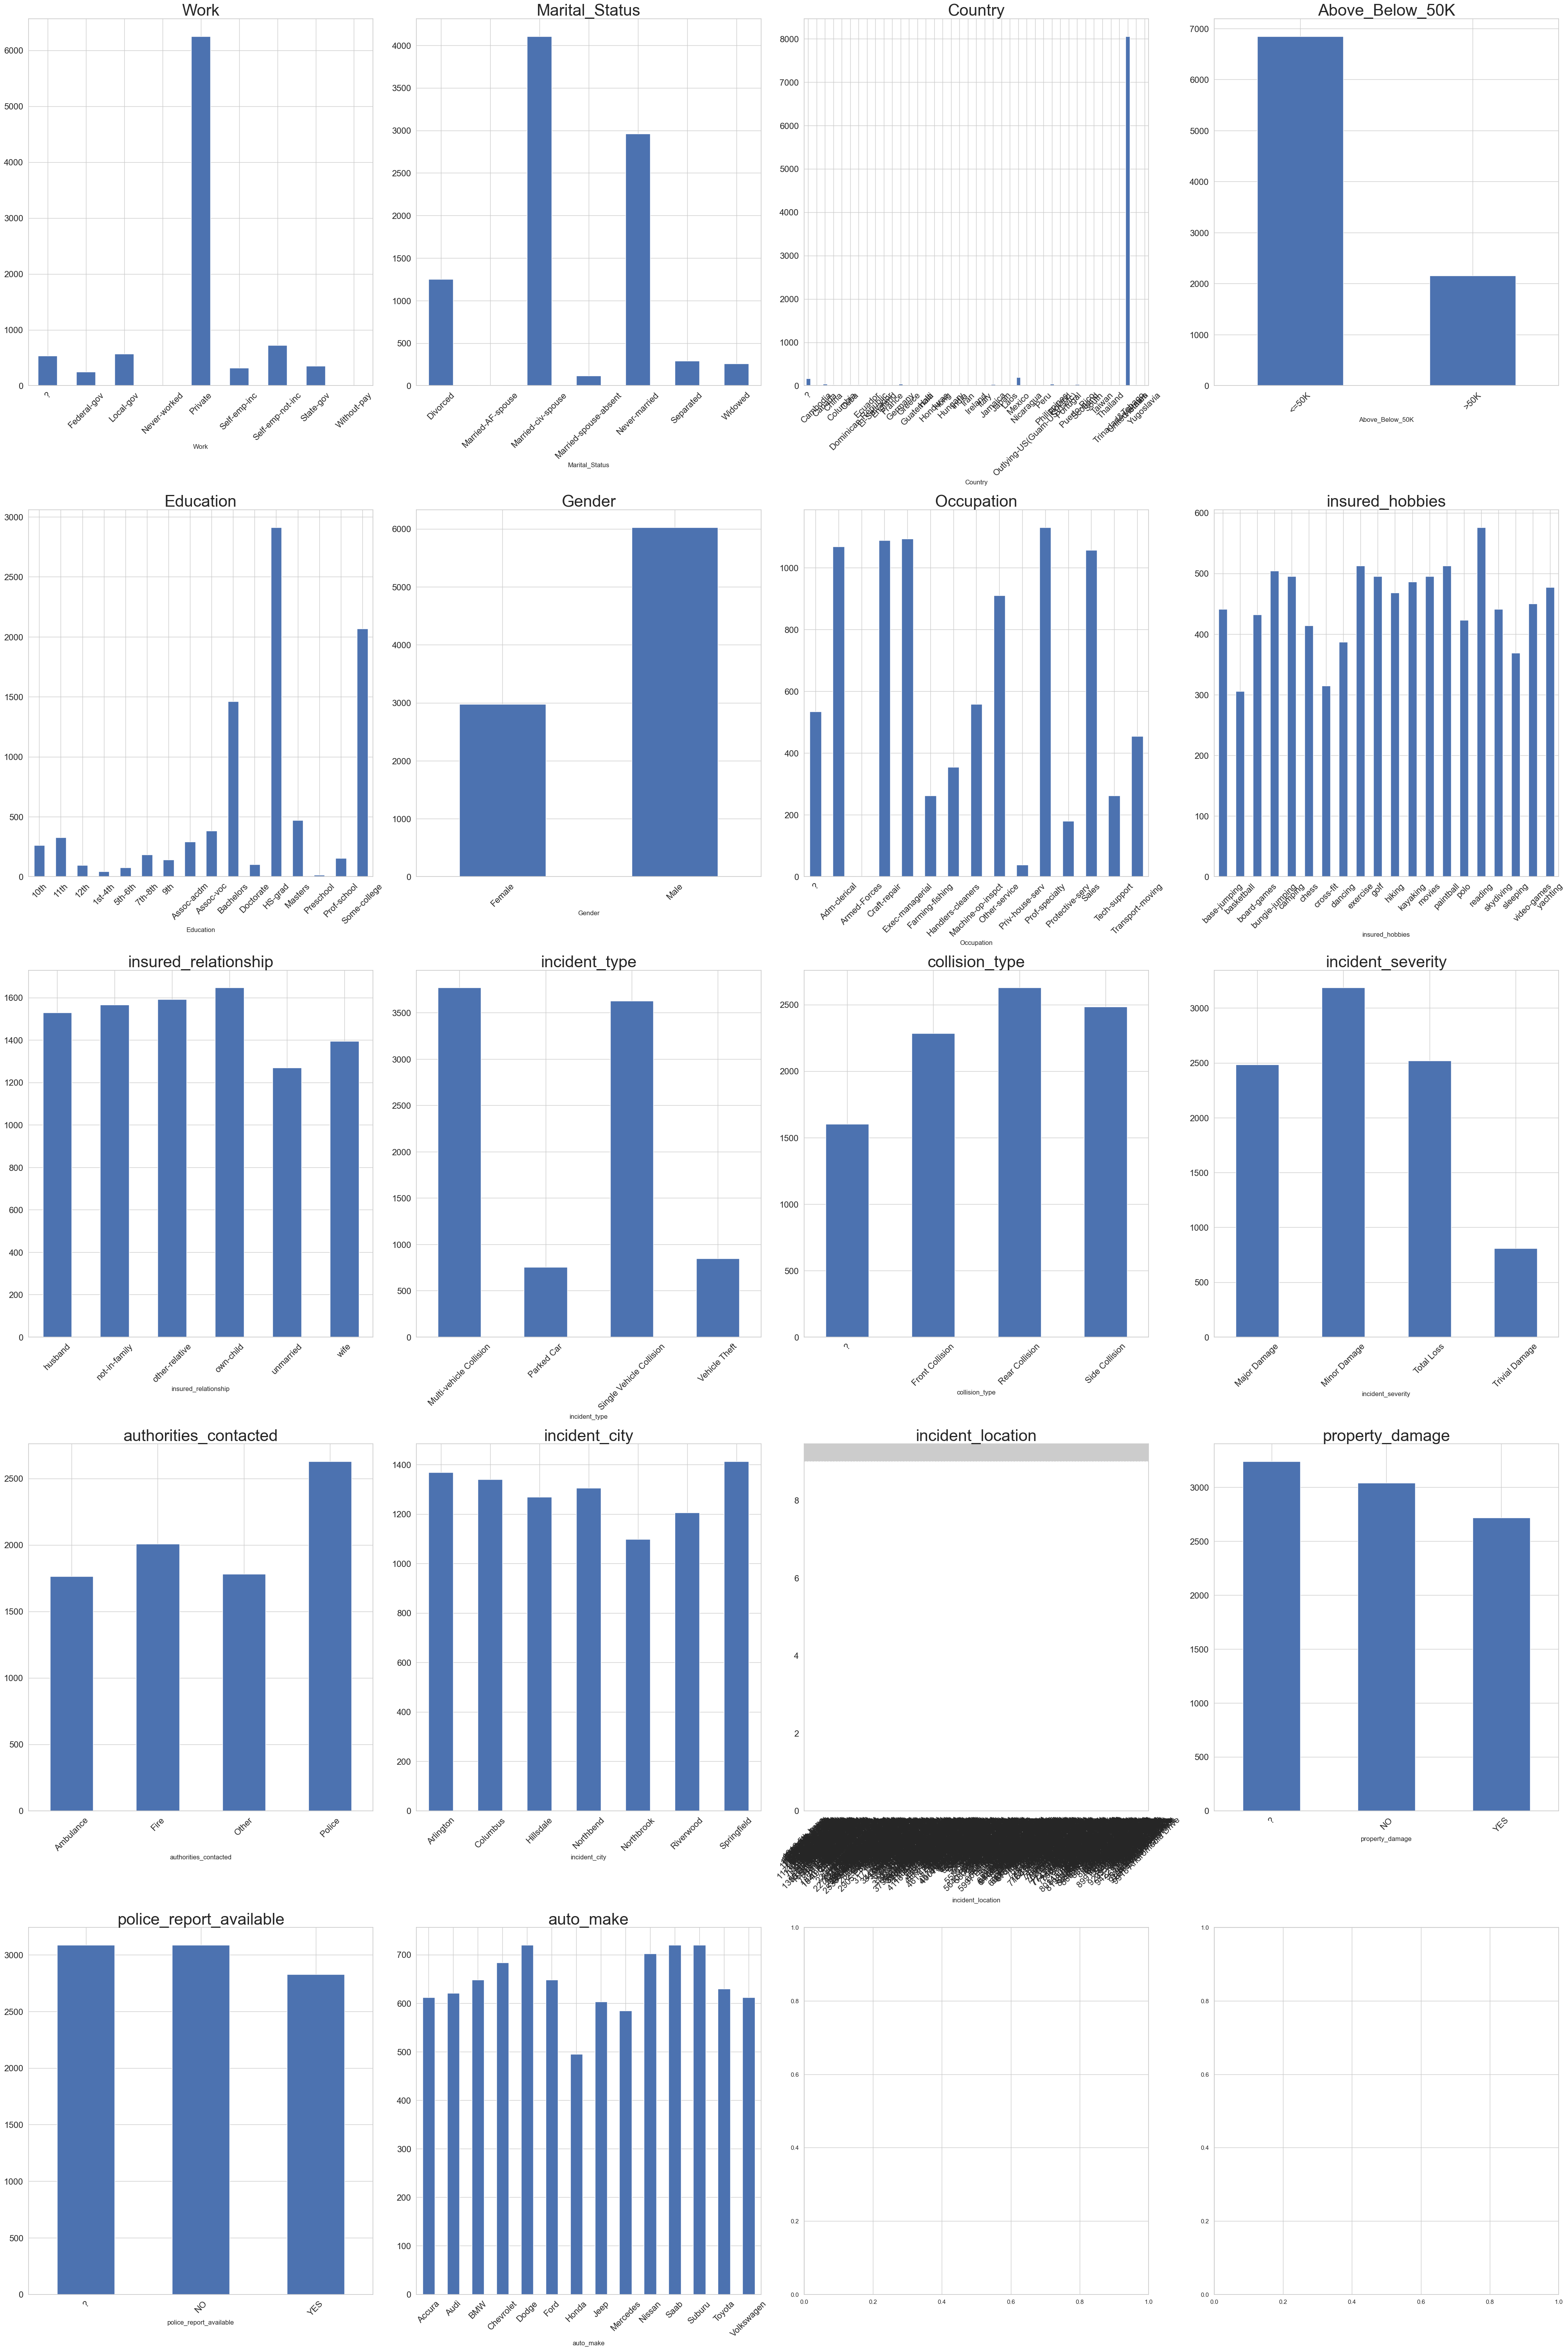

In [22]:
fig, ax = plt.subplots(5, 4, figsize=(40,60), constrained_layout=True)
for i in range(5):
    for j in range(4):
        if 4*i + j < len(cat_features):
            df[cat_features[4*i + j]].value_counts().sort_index().plot.bar(ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].tick_params(labelsize=16)
            ax[i, j].set_title(cat_features[4*i + j], size=30)

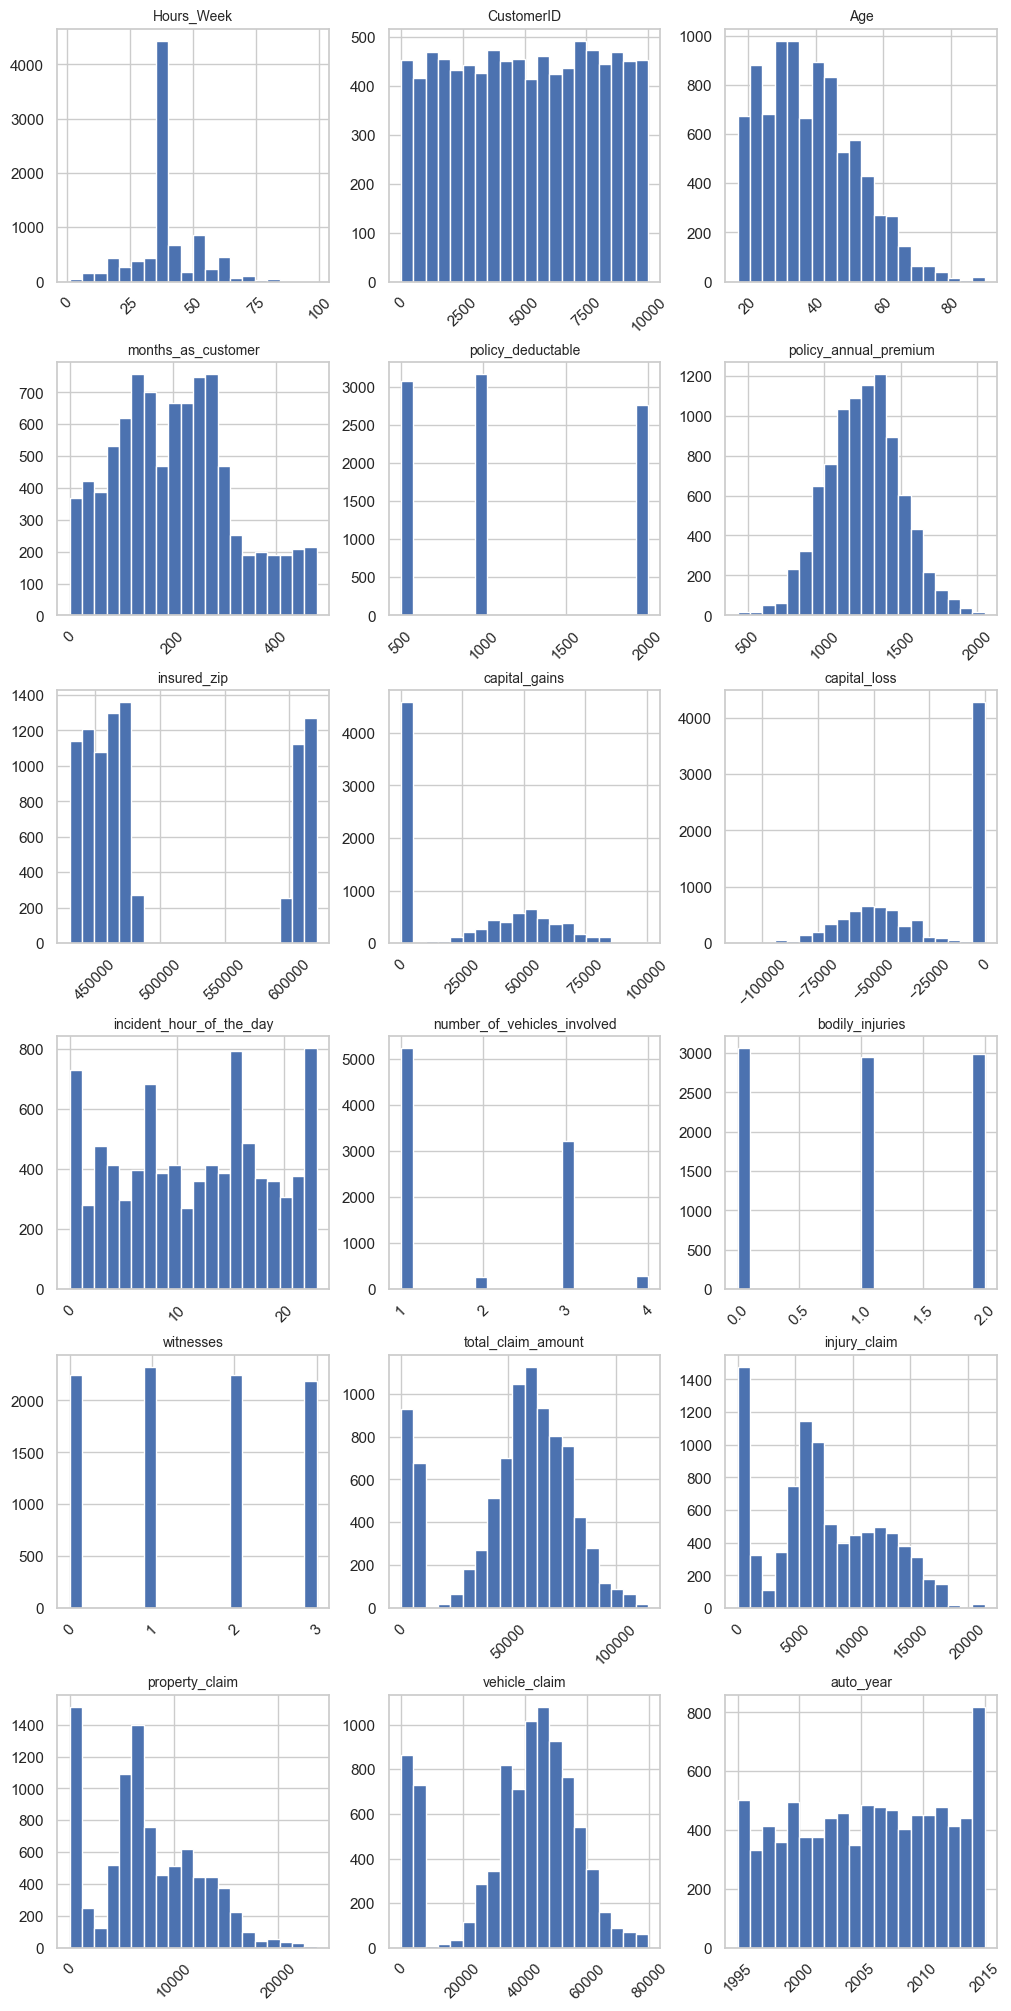

In [23]:
fig, ax = plt.subplots(6, 3, figsize=(10,20), constrained_layout=True)
for i in range(6):
    for j in range(3):
        if 2*i + j < len(num_features):
            df[num_features[3*i + j]].hist(bins=20, ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].set_title(num_features[3*i + j],size=10)

/var/folders/y0/rgr2l6md3fn37h8vzc_vdb2h0000gn/T/ipykernel_18743/4158334210.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");


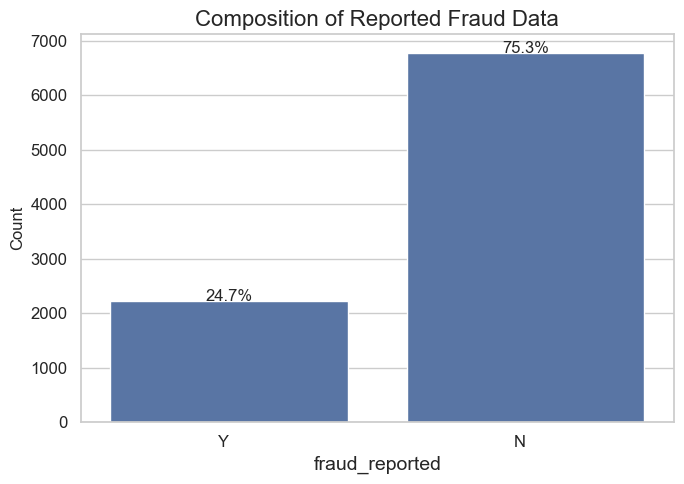

In [24]:
plt.figure(figsize =(7,5))
ax = sns.countplot(data = df, x = 'fraud_reported')
plt.xticks(size = 12)
plt.xlabel('fraud_reported', size = 14)
plt.yticks(size = 12)
plt.ylabel('Count', size = 12)
plt.title("Composition of Reported Fraud Data", size = 16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.tight_layout()
plt.show()

# Pre-Pipeline

In [25]:
df.dropna()

# Membersihkan Missing Value
df.replace({'?':'NaN'}, inplace=True)

# Mengubah Nama Fitur
df = df.rename(columns={'Above_Below_50K_<=50K': 'Below_50K', 'Above_Below_50K_>50K': 'Above_50K'})

# Menampilkan Data
df.head(5)

Work      Marital_Status  Hours_Week        Country  \
0  Self-emp-not-inc  Married-civ-spouse          13  United-States   
1           Private            Divorced          40  United-States   
2           Private  Married-civ-spouse          40  United-States   
3           Private  Married-civ-spouse          40           Cuba   
4           Private  Married-civ-spouse          40  United-States   

  Above_Below_50K  Education  Gender         Occupation  CustomerID  Age  ...  \
0           <=50K  Bachelors    Male    Exec-managerial         902   50  ...   
1           <=50K    HS-grad    Male  Handlers-cleaners        5506   38  ...   
2           <=50K       11th    Male  Handlers-cleaners        3869   53  ...   
3           <=50K  Bachelors  Female     Prof-specialty        7106   28  ...   
4           <=50K    Masters  Female    Exec-managerial        1760   37  ...   

   bodily_injuries  witnesses  police_report_available  total_claim_amount  \
0                1          2                      YES               71610   
1                0          0                      NaN                5070   
2                2          3                       NO               34650   
3                1          2                       NO               63400   
4                0          1                       NO                6500   

  injury_claim property_claim  vehicle_claim  auto_make auto_year  \
0         6510          13020          52080       Saab      2004   
1          780            780           3510   Mercedes      2007   
2         7700           3850          23100      Dodge      2007   
3         6340           6340          50720  Chevrolet      2014   
4         1300            650           4550     Accura      2009   

  fraud_reported  
0              Y  
1              Y  
2              N  
3              Y  
4              N  

[5 rows x 37 columns]

In [26]:
label_1 = df['fraud_reported']
label = label_1.replace({'N': 0, 'Y': 1})
data = df.drop(['fraud_reported'], axis=1)
feature_names = data.columns

/var/folders/y0/rgr2l6md3fn37h8vzc_vdb2h0000gn/T/ipykernel_18743/2647141367.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  label = label_1.replace({'N': 0, 'Y': 1})


In [27]:
x_train, x_test, y_train, y_test = train_test_split(data,label, train_size=0.8, random_state=1)

In [28]:
x_train

Work      Marital_Status  Hours_Week        Country  \
7289       Private  Married-civ-spouse          40  United-States   
8192       Private  Married-civ-spouse          50  United-States   
6247       Private  Married-civ-spouse          40  United-States   
8073  Self-emp-inc  Married-civ-spouse          50  United-States   
7804  Self-emp-inc  Married-civ-spouse          54  United-States   
...            ...                 ...         ...            ...   
2895     Local-gov       Never-married          40         Taiwan   
7813       Private            Divorced          40  United-States   
905        Private            Divorced          52  United-States   
5192     Local-gov            Divorced          40  United-States   
235      State-gov       Never-married          38  United-States   

     Above_Below_50K     Education  Gender         Occupation  CustomerID  \
7289           <=50K     Bachelors    Male              Sales        4703   
8192            >50K     Bachelors    Male     Prof-specialty        2614   
6247            >50K     Bachelors    Male       Craft-repair        7894   
8073           <=50K       HS-grad    Male    Farming-fishing        9224   
7804            >50K  Some-college    Male              Sales        1537   
...              ...           ...     ...                ...         ...   
2895           <=50K       Masters    Male     Prof-specialty         399   
7813           <=50K  Some-college    Male      Other-service        7655   
905            <=50K  Some-college    Male  Machine-op-inspct        9489   
5192           <=50K  Some-college  Female       Adm-clerical        3379   
235            <=50K  Some-college  Female       Adm-clerical        6399   

      Age  ...  property_damage  bodily_injuries  witnesses  \
7289   33  ...               NO                0          2   
8192   38  ...               NO                0          3   
6247   43  ...              NaN                0          1   
8073   50  ...               NO                2          0   
7804   54  ...              YES                2          3   
...   ...  ...              ...              ...        ...   
2895   29  ...              NaN                0          3   
7813   59  ...              NaN                1          2   
905    37  ...               NO                1          2   
5192   43  ...               NO                0          3   
235    40  ...               NO                1          0   

      police_report_available total_claim_amount injury_claim  property_claim  \
7289                      NaN               8760         1460            1460   
8192                       NO              55500         5550           11100   
6247                      NaN              98670        15180           15180   
8073                      YES              57120         9520            4760   
7804                      YES               4950          900             450   
...                       ...                ...          ...             ...   
2895                      NaN              55200        11040            5520   
7813                       NO               3520          640             320   
905                       NaN              64300         6430            6430   
5192                       NO              55500         5550           11100   
235                       NaN              76560        12760            6380   

      vehicle_claim  auto_make auto_year  
7289           5840        BMW      2013  
8192          38850   Mercedes      2012  
6247          68310  Chevrolet      2010  
8073          42840   Mercedes      2002  
7804           3600     Toyota      1995  
...             ...        ...       ...  
2895          38640       Saab      1998  
7813           2560     Accura      2013  
905           51440  Chevrolet      2002  
5192          38850   Mercedes      2012  
235           57420     Nissan      2009  

[7200 rows x 

In [29]:
y_train

7289    0
8192    0
6247    1
8073    0
7804    0
       ..
2895    1
7813    0
905     1
5192    0
235     0
Name: fraud_reported, Length: 7200, dtype: int64

In [30]:
# Define preprocessor for one-hot encoding and min-max scaling

cat_col = ['Work','Marital_Status','Country','Above_Below_50K','Education','Gender','Occupation',
                'insured_hobbies','insured_relationship','incident_type','collision_type',
                'incident_severity','authorities_contacted','incident_city','incident_location',
                'property_damage', 'police_report_available','auto_make']

num_col = ['Hours_Week','CustomerID','Age','months_as_customer','policy_deductable',
                'policy_annual_premium','insured_zip','capital_gains','capital_loss',
                'incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
                'witnesses','total_claim_amount','injury_claim','property_claim',
                'vehicle_claim','auto_year']

### Transformers for numerical data
numerical_transformer = Pipeline(steps=[('Scaler', MinMaxScaler())])

### Transformers for categorical data
categorical_transformer = Pipeline(steps=[('Encoder', OneHotEncoder(handle_unknown='ignore'))])


### Combine pipelines using ColumnTransformer
preprocessing = ColumnTransformer(transformers=[('Numerical', numerical_transformer, num_col),
                                                ('Categorical', categorical_transformer, cat_col)],
                                  remainder='passthrough')

# PIPELINE
- Decision Tree
- Random Forest
- XGBoost
- Approximating XGBoost

## DECISION TREE

### Model

In [30]:
param_dt = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

# Create pipelines with SMOTE for each model (nested GridSearchCV)
dt_grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=param_dt, scoring='roc_auc', cv=5)

dt_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', dt_grid)
])

dt_pipeline.fit(x_train, y_train)

/Users/adlir/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Hours_Week', 'CustomerID',
                                                   'Age', 'months_as_customer',
                                                   'policy_deductable',
                                                   'policy_annual_premium',
                                                   'insured_zip',
                                                   'capital_gains',
                                                   'capital_loss',
                                                   'incident_hour_of_the_day',
                                                   'number_of_vehicles_involved',
                                                   'bod...
                                                   'police_report_available',
                                                   'auto_make'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(criterion='entropy'),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [31]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = dt_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': np.int64(9), 'min_samples_leaf': 50, 'min_samples_split': 100}


In [32]:
pd.DataFrame(dt_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
401       0.108643      0.001409         0.002394        0.000312   
400       0.108650      0.001531         0.002357        0.000328   
301       0.103310      0.001647         0.002347        0.000332   
300       0.103067      0.001571         0.002417        0.000364   
402       0.105037      0.001582         0.002403        0.000283   
..             ...           ...              ...             ...   
94        0.060926      0.003792         0.002733        0.000223   
92        0.059899      0.002194         0.002335        0.000297   
91        0.059715      0.002036         0.002487        0.000367   
99        0.061418      0.002435         0.002473        0.000330   
93        0.059280      0.002336         0.002379        0.000337   

     param_max_depth  param_min_samples_leaf  param_min_samples_split  \
401                9                      50                      100   
400                9                      50                       50   
301                8                      50                      100   
300                8                      50                       50   
402                9                      50                      150   
..               ...                     ...                      ...   
94                 5                     500                      250   
92                 5                     500                      150   
91                 5                     500                      100   
99                 5                     500                      500   
93                 5                     500                      200   

                                                params  split0_test_score  \
401  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.950168   
400  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.950168   
301  {'max_depth': 8, 'min_samples_leaf': 50, 'min_...           0.942801   
300  {'max_depth': 8, 'min_samples_leaf': 50, 'min_...           0.942801   
402  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.942088   
..                                                 ...                ...   
94   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.870402   
92   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.870402   
91   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.870402   
99   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.870402   
93   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.870402   

     split1_test_score  split2_test_score  split3_test_score  \
401           0.964584           0.975295           0.975059   
400           0.964584           0.974541           0.975154   
301           0.958776           0.967466           0.970149   
300           0.958776           0.966839           0.970214   
402           0.952416           0.971474           0.966328   
..                 ...                ...                ...   
94            0.888287           0.888026           0.879316   
92            0.888287           0.888026           0.879316   
91            0.888287           0.888026           0.879316   
99            0.888287           0.888026           0.879316   
93            0.888287           0.888026           0.879316   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
401           0.976625         0.968346        0.010065                1  
400           0.976617         0.968213        0.009976                2  
301           0.963691         0.960577        0.009675                3  
300           0.963691         0.960464        0.009602                4  
402           0.966426         0.959747        0.010872                5  
..                 ...              ...             ...              ...  
94            0.895916         0.884389        0.008748              491  
92   

In [33]:
joblib.dump(dt_pipeline, 'model_dt9.h5')

['model_dt9.h5']

### Statistical Performances

In [34]:
train_dt = dt_pipeline.predict(x_test)
print(classification_report(y_test, train_dt))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1361
           1       0.76      0.95      0.84       439

    accuracy                           0.91      1800
   macro avg       0.87      0.92      0.89      1800
weighted avg       0.93      0.91      0.92      1800



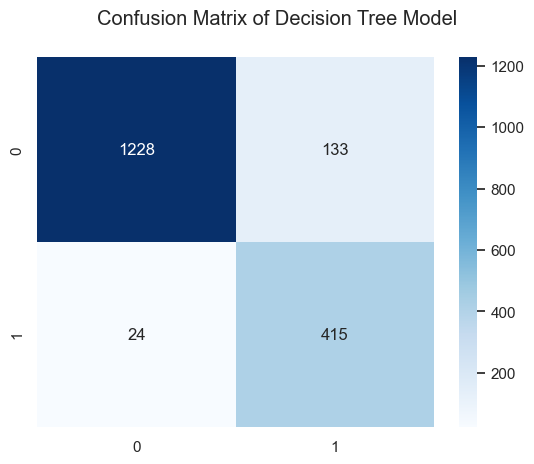

In [35]:
cm = confusion_matrix(y_test, train_dt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Decision Tree Model")
plt.show()

In [36]:
# Calculate ROC AUC
probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.9804419904297892
Specificity: 0.9022777369581191
Sensitivity: 0.9453302961275627


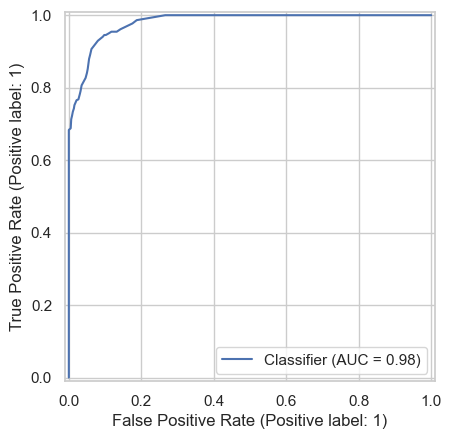

In [37]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [38]:
model_dt = DecisionTreeClassifier(criterion='entropy',**dt_pipeline.named_steps['grid_search'].best_params_)

dt_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_dt)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    dt_pipeline.fit(x_train, y_train)

    train_dt = dt_pipeline.predict(x_test)

    # Calculate ROC AUC
    probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_dt)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.9804419904297892
Specificity = 0.9022777369581191
Sensitivity = 0.9453302961275627
 
iteration2
ROC_AUC = 0.9804419904297892
Specificity = 0.9022777369581191
Sensitivity = 0.9453302961275627
 
iteration3
ROC_AUC = 0.9804419904297892
Specificity = 0.9022777369581191
Sensitivity = 0.9453302961275627
 
iteration4
ROC_AUC = 0.9804419904297892
Specificity = 0.9022777369581191
Sensitivity = 0.9453302961275627
 
iteration5
ROC_AUC = 0.9804419904297892
Specificity = 0.9022777369581191
Sensitivity = 0.9453302961275627
 


## RANDOM FOREST

### Model

In [39]:
param_rf = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=250,
                                              criterion='entropy',
                                              n_jobs=-1),
                       param_grid=param_rf, scoring='roc_auc',cv=5)

rf_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', rf_grid)
])

rf_pipeline.fit(x_train, y_train)

/Users/adlir/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Hours_Week', 'CustomerID',
                                                   'Age', 'months_as_customer',
                                                   'policy_deductable',
                                                   'policy_annual_premium',
                                                   'insured_zip',
                                                   'capital_gains',
                                                   'capital_loss',
                                                   'incident_hour_of_the_day',
                                                   'number_of_vehicles_involved',
                                                   'bod...
                                                   'auto_make'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(criterion='entropy',
                                                               n_estimators=250,
                                                               n_jobs=-1),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [40]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = rf_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': np.int64(9), 'min_samples_leaf': 50, 'min_samples_split': 100}


In [41]:
pd.DataFrame(rf_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
401       0.678062      0.097392         0.054172        0.007294   
402       0.637407      0.016800         0.061712        0.011133   
400       0.642867      0.073487         0.073284        0.031406   
403       0.630927      0.024883         0.058235        0.019889   
300       0.658115      0.055058         0.070552        0.020017   
..             ...           ...              ...             ...   
96        0.313444      0.018694         0.034298        0.007071   
493       0.606108      0.048356         0.063342        0.013961   
393       0.576669      0.068831         0.063982        0.012118   
92        0.317950      0.011965         0.036693        0.006200   
391       0.573553      0.051875         0.064095        0.024119   

     param_max_depth  param_min_samples_leaf  param_min_samples_split  \
401                9                      50                      100   
402                9                      50                      150   
400                9                      50                       50   
403                9                      50                      200   
300                8                      50                       50   
..               ...                     ...                      ...   
96                 5                     500                      350   
493                9                     500                      200   
393                8                     500                      200   
92                 5                     500                      150   
391                8                     500                      100   

                                                params  split0_test_score  \
401  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.878543   
402  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.882703   
400  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.875155   
403  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.878367   
300  {'max_depth': 8, 'min_samples_leaf': 50, 'min_...           0.873562   
..                                                 ...                ...   
96   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.791728   
493  {'max_depth': 9, 'min_samples_leaf': 500, 'min...           0.790067   
393  {'max_depth': 8, 'min_samples_leaf': 500, 'min...           0.786544   
92   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.778280   
391  {'max_depth': 8, 'min_samples_leaf': 500, 'min...           0.790512   

     split1_test_score  split2_test_score  split3_test_score  \
401           0.911993           0.958165           0.960010   
402           0.909140           0.955559           0.953726   
400           0.911956           0.952807           0.957621   
403           0.904890           0.950165           0.952924   
300           0.909807           0.949676           0.955164   
..                 ...                ...                ...   
96            0.837128           0.864031           0.880411   
493           0.837879           0.868519           0.878127   
393           0.836443           0.869132           0.880020   
92            0.841221           0.869526           0.878147   
391           0.835208           0.864583           0.875673   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
401           0.958457         0.933434        0.032914                1  
402           0.962445         0.932715        0.031318                2  
400           0.958651         0.931238        0.032954                3  
403           0.961590         0.929587        0.032329                4  
300           0.957982         0.929238        0.032844                5  
..                 ...              ...             ...              ...  
96            0.884191         0.851498        0.034178              496  
493  

In [42]:
joblib.dump(rf_pipeline, 'model_rf9.h5')

['model_rf9.h5']

### Statistical Performances

In [43]:
train_rf = rf_pipeline.predict(x_test)
print(classification_report(y_test, train_rf))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1361
           1       0.65      0.71      0.68       439

    accuracy                           0.83      1800
   macro avg       0.77      0.79      0.78      1800
weighted avg       0.84      0.83      0.84      1800



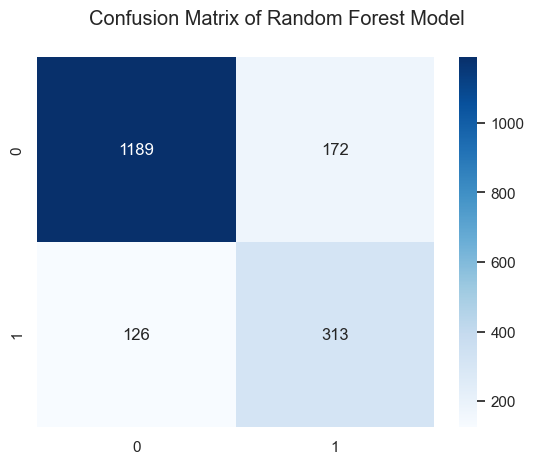

In [44]:
cm = confusion_matrix(y_test, train_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Random Forest Model")
plt.show()

In [45]:
# Menghitung F1-Score untuk label positif
f1 = f1_score(y_test, train_rf, pos_label=1)

# Calculate ROC AUC
probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.88364444608095
Specificity: 0.8736223365172667
Sensitivity: 0.7129840546697038


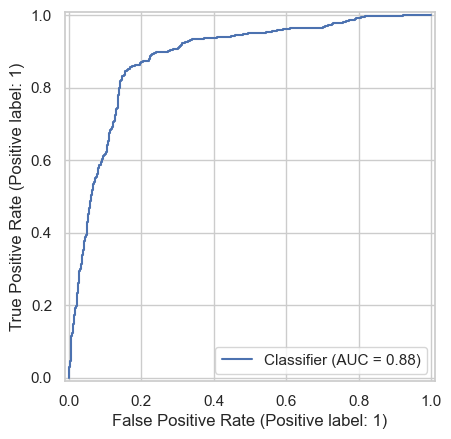

In [46]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [47]:
model_rf = RandomForestClassifier(n_estimators=250, criterion='entropy',**rf_pipeline.named_steps['grid_search'].best_params_)

rf_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_rf)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    rf_pipeline.fit(x_train, y_train)

    train_rf = rf_pipeline.predict(x_test)

    # Calculate ROC AUC
    probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_rf)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.8810920551182552
Specificity = 0.8758265980896399
Sensitivity = 0.7312072892938497
 
iteration2
ROC_AUC = 0.8793447133706791
Specificity = 0.8750918442321822
Sensitivity = 0.7061503416856492
 
iteration3
ROC_AUC = 0.8806652618753129
Specificity = 0.8706833210874357
Sensitivity = 0.7357630979498861
 
iteration4
ROC_AUC = 0.8811891296597871
Specificity = 0.8706833210874357
Sensitivity = 0.7175398633257403
 
iteration5
ROC_AUC = 0.8771605361862091
Specificity = 0.8758265980896399
Sensitivity = 0.6947608200455581
 


## XGBOOST

### Model

In [48]:
param_xgb_main = {'max_depth': np.arange(5, 10),
                  'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                  'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
                  'n_estimators': [100, 200, 300, 400, 500],
                  'lambda': np.arange(0, 10),
                  'gamma': np.arange(0, 10),
                  'colsample_bytree':np.arange(0.5, 1),
                  'min_child_weight':np.arange(4, 10)}

In [49]:
param_xgb = {'max_depth': np.arange(5, 10),
             'eta': [0.01, 0.05, 0.10, 0.15, 0.20],
             'gamma': np.arange(0, 10),
             'lambda': np.arange(0, 10)}

xgb_grid = GridSearchCV(XGBClassifier(n_estimators=250,
                                      subsample=0.8,
                                      objective='binary:logistic',
                                      eval_metric='logloss'),
                        param_grid=param_xgb, cv=5, scoring ='roc_auc', n_jobs=-1)

xgb_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('grid_search', xgb_grid)])

xgb_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['Hours_Week', 'CustomerID',
                                                   'Age', 'months_as_customer',
                                                   'policy_deductable',
                                                   'policy_annual_premium',
                                                   'insured_zip',
                                                   'capital_gains',
                                                   'capital_loss',
                                                   'incident_hour_of_the_day',
                                                   'number_of_vehicles_involved',
                                                   'bod...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=250,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                                          'gamma': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'lambda': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'max_depth': array([5, 6, 7, 8, 9])},
                              scoring='roc_auc'))])

In [50]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = xgb_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'eta': 0.05, 'gamma': np.int64(0), 'lambda': np.int64(0), 'max_depth': np.int64(8)}


In [51]:
pd.DataFrame(xgb_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_eta  \
1013       8.848634      0.109071         0.188040        0.019820       0.10   
2022       6.550674      0.048776         0.186252        0.016605       0.20   
2021       5.956881      0.094755         0.145439        0.012244       0.20   
2020       5.049184      0.081118         0.137880        0.031271       0.20   
2019       6.818387      0.115782         0.152543        0.017292       0.20   
...             ...           ...              ...             ...        ...   
485        5.817935      0.054659         0.096804        0.028138       0.01   
235        5.614243      0.181160         0.073783        0.018059       0.01   
495        5.784846      0.088449         0.106460        0.016767       0.01   
285        5.689775      0.140414         0.094100        0.027568       0.01   
490        5.820113      0.095703         0.093350        0.012229       0.01   

      param_gamma  param_lambda  param_max_depth  \
1013            0             2                8   
2022            0             4                7   
2021            0             4                6   
2020            0             4                5   
2019            0             3                9   
...           ...           ...              ...   
485             9             7                5   
235             4             7                5   
495             9             9                5   
285             5             7                5   
490             9             8                5   

                                                 params  split0_test_score  \
1013  {'eta': 0.1, 'gamma': 0, 'lambda': 2, 'max_dep...           1.000000   
2022  {'eta': 0.2, 'gamma': 0, 'lambda': 4, 'max_dep...           1.000000   
2021  {'eta': 0.2, 'gamma': 0, 'lambda': 4, 'max_dep...           1.000000   
2020  {'eta': 0.2, 'gamma': 0, 'lambda': 4, 'max_dep...           1.000000   
2019  {'eta': 0.2, 'gamma': 0, 'lambda': 3, 'max_dep...           1.000000   
...                                                 ...                ...   
485   {'eta': 0.01, 'gamma': 9, 'lambda': 7, 'max_de...           0.901917   
235   {'eta': 0.01, 'gamma': 4, 'lambda': 7, 'max_de...           0.901920   
495   {'eta': 0.01, 'gamma': 9, 'lambda': 9, 'max_de...           0.903516   
285   {'eta': 0.01, 'gamma': 5, 'lambda': 7, 'max_de...           0.901889   
490   {'eta': 0.01, 'gamma': 9, 'lambda': 8, 'max_de...           0.900825   

      split1_test_score  split2_test_score  split3_test_score  \
1013           1.000000           1.000000           1.000000   
2022           1.000000           1.000000           1.000000   
2021           1.000000           1.000000           1.000000   
2020           1.000000           1.000000           1.000000   
2019           1.000000           1.000000           1.000000   
...                 ...                ...                ...   
485            0.931442           0.994141           0.995064   
235            0.931435           0.993938           0.995089   
495            0.931171           0.993594           0.994698   
285            0.931437           0.993940           0.995081   
490            0.931049           0.993738           0.994854   

      split4_test_score  mean_test_score  std_test_score  rank_test_score  
1013           1.000000         1.000000    0.000000e+00                1  
2022           1.000000         1.000000    0.000000e+00                1  
2021           1.000000         1.000000    4.965068e-17                1  
2020           1.000000         1.000000    4.965068e-17                1  
2019           1.000000         1.000000    0.000000e+00                1  
...                 ...              ...             ...              ...  
485            0.994171         0.963347    3.923241e-02             2496  
235            0.994342         0.963345    3.923190e-02             2497  
495   

In [52]:
joblib.dump(xgb_pipeline, 'model_xgb9.h5')

['model_xgb9.h5']

### Statistical Performances

In [53]:
train_xgb = xgb_pipeline.predict(x_test)
print(classification_report(y_test, train_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1361
           1       1.00      1.00      1.00       439

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



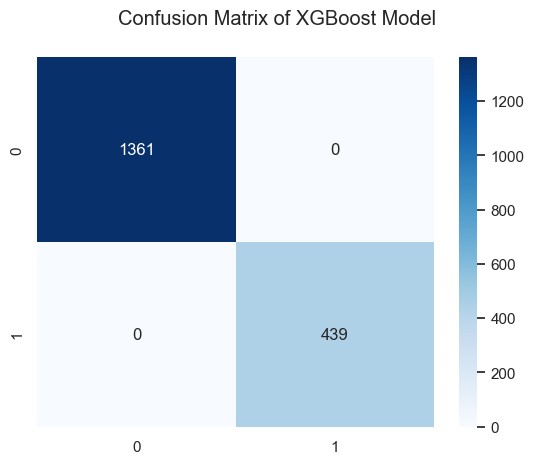

In [54]:
cm = confusion_matrix(y_test, train_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of XGBoost Model")
plt.show()

In [55]:
# Calculate ROC AUC
probabilities = xgb_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 1.0
Specificity: 1.0
Sensitivity: 1.0


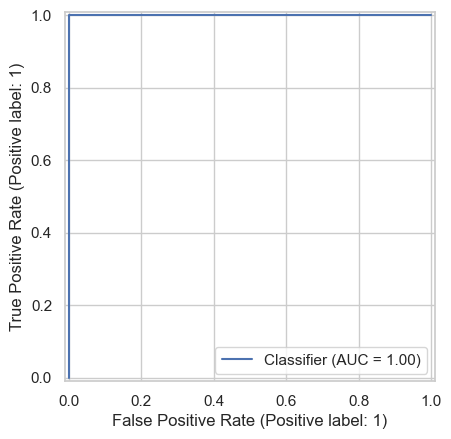

In [56]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [57]:
model_xgb = XGBClassifier(n_estimators=250,
                          subsample=0.8,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          **xgb_pipeline.named_steps['grid_search'].best_params_)

In [31]:
model_xgb = XGBClassifier(n_estimators=250,
                          subsample=0.8,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          eta=0.05, gamma=0, reg_lambda=0, max_depth=8)

In [32]:
xgb_pipelines = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_xgb)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    xgb_pipelines.fit(x_train, y_train)

    train_xgb = xgb_pipelines.predict(x_test)

    # Calculate ROC AUC
    probabilities = xgb_pipelines.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_xgb)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 1.0
Specificity = 1.0
Sensitivity = 1.0
 
iteration2
ROC_AUC = 1.0
Specificity = 1.0
Sensitivity = 1.0
 
iteration3
ROC_AUC = 1.0
Specificity = 1.0
Sensitivity = 1.0
 
iteration4
ROC_AUC = 1.0
Specificity = 1.0
Sensitivity = 1.0
 
iteration5
ROC_AUC = 1.0
Specificity = 1.0
Sensitivity = 1.0
 


## APPROXIMATING XGBOOST

### Pre-Modeling

In [33]:
#one-hot encode categorical data
encoder = OneHotEncoder(sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(data[cat_col]))
df_encoded.columns = encoder.get_feature_names_out(cat_col)

#scale numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[num_col])
df_scaled = pd.DataFrame(scaled_data, columns=num_col)

df_preprocessed = pd.concat([df_encoded, df_scaled], axis=1)
df_preprocessed

Work_Federal-gov  Work_Local-gov  Work_NaN  Work_Never-worked  \
0                  0.0             0.0       0.0                0.0   
1                  0.0             0.0       0.0                0.0   
2                  0.0             0.0       0.0                0.0   
3                  0.0             0.0       0.0                0.0   
4                  0.0             0.0       0.0                0.0   
...                ...             ...       ...                ...   
8995               0.0             0.0       0.0                0.0   
8996               0.0             0.0       0.0                0.0   
8997               0.0             0.0       0.0                0.0   
8998               0.0             0.0       0.0                0.0   
8999               0.0             0.0       0.0                0.0   

      Work_Private  Work_Self-emp-inc  Work_Self-emp-not-inc  Work_State-gov  \
0              0.0                0.0                    1.0             0.0   
1              1.0                0.0                    0.0             0.0   
2              1.0                0.0                    0.0             0.0   
3              1.0                0.0                    0.0             0.0   
4              1.0                0.0                    0.0             0.0   
...            ...                ...                    ...             ...   
8995           1.0                0.0                    0.0             0.0   
8996           1.0                0.0                    0.0             0.0   
8997           0.0                0.0                    1.0             0.0   
8998           0.0                0.0                    1.0             0.0   
8999           1.0                0.0                    0.0             0.0   

      Work_Without-pay  Marital_Status_Divorced  ...  capital_loss  \
0                  0.0                      0.0  ...      1.000000   
1                  0.0                      1.0  ...      1.000000   
2                  0.0                      0.0  ...      1.000000   
3                  0.0                      0.0  ...      0.438344   
4                  0.0                      0.0  ...      0.585959   
...                ...                      ...  ...           ...   
8995               0.0                      0.0  ...      1.000000   
8996               0.0                      0.0  ...      1.000000   
8997               0.0                      0.0  ...      1.000000   
8998               0.0                      1.0  ...      1.000000   
8999               0.0                      0.0  ...      1.000000   

      incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
0                     0.217391                     0.000000              0.5   
1                     0.347826                     0.000000              0.0   
2                     0.304348                     0.666667              1.0   
3                     0.217391                     0.000000              0.5   
4                     0.869565                     0.000000              0.0   
...                        ...                          ...              ...   
8995                  0.869565                     0.000000              0.0   
8996                  1.000000                     0.000000              1.0   
8997                  0.173913                     0.666667              1.0   
8998                  0.086957                     0.000000              0.0   
8999                  0.260870                     0.000000              0.0   

      witnesses  total_claim_amount  injury_claim  property_claim  \
0      0.666667            0.622801      0.303497        0.550063   
1      0.000000            0.043285      0.036364        0.032953   
2      1.000000            0.300906      0.358974        0.162653   
3      0.666667            0.551298      0.295571        0.267850   
4      0.333333            0.055739      0.06

In [34]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_preprocessed, label, train_size=0.8, random_state=1)

In [35]:
# Create SMOTE object
smote = SMOTE(random_state=1)

# Transform data
x_smote, y_smote = smote.fit_resample(x_train2, y_train2)

In [36]:
# Mengubah Nama Fitur
x_smote = x_smote.rename(columns={'Above_Below_50K_<=50K': 'Below_50K', 'Above_Below_50K_>50K': 'Above_50K'})
x_smote

Work_Federal-gov  Work_Local-gov  Work_NaN  Work_Never-worked  \
0                   0.0             0.0       0.0                0.0   
1                   0.0             0.0       0.0                0.0   
2                   0.0             0.0       0.0                0.0   
3                   0.0             0.0       0.0                0.0   
4                   0.0             0.0       0.0                0.0   
...                 ...             ...       ...                ...   
10827               0.0             0.0       0.0                0.0   
10828               0.0             0.0       0.0                0.0   
10829               0.0             0.0       0.0                0.0   
10830               0.0             0.0       0.0                0.0   
10831               0.0             0.0       0.0                0.0   

       Work_Private  Work_Self-emp-inc  Work_Self-emp-not-inc  Work_State-gov  \
0          1.000000                0.0               0.000000             0.0   
1          1.000000                0.0               0.000000             0.0   
2          1.000000                0.0               0.000000             0.0   
3          0.000000                1.0               0.000000             0.0   
4          0.000000                1.0               0.000000             0.0   
...             ...                ...                    ...             ...   
10827      1.000000                0.0               0.000000             0.0   
10828      0.115164                0.0               0.884836             0.0   
10829      1.000000                0.0               0.000000             0.0   
10830      1.000000                0.0               0.000000             0.0   
10831      1.000000                0.0               0.000000             0.0   

       Work_Without-pay  Marital_Status_Divorced  ...  capital_loss  \
0                   0.0                 0.000000  ...      0.700270   
1                   0.0                 0.000000  ...      1.000000   
2                   0.0                 0.000000  ...      0.627363   
3                   0.0                 0.000000  ...      0.613861   
4                   0.0                 0.000000  ...      1.000000   
...                 ...                      ...  ...           ...   
10827               0.0                 0.673555  ...      1.000000   
10828               0.0                 0.000000  ...      1.000000   
10829               0.0                 0.000000  ...      0.472547   
10830               0.0                 0.000000  ...      1.000000   
10831               0.0                 0.000000  ...      1.000000   

       incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
0                      0.347826                     0.000000              0.0   
1                      0.565217                     0.000000              0.0   
2                      0.652174                     0.666667              0.0   
3                      0.304348                     0.666667              1.0   
4                      0.130435                     0.000000              1.0   
...                         ...                          ...              ...   
10827                  0.130435                     0.000000              1.0   
10828                  0.173913                     0.666667              0.5   
10829                  0.782609                     0.000000              0.5   
10830                  0.130435                     0.000000              0.5   
10831                  0.434783                     0.000000              0.0   

       witnesses  total_claim_amount  injury_claim  property_claim  \
0       0.666667            0.075422      0.068065        0.061681   
1       1.000000            0.482494      0.258741        0.468948   
2       0.333333            0.858474      0.707692        0.641318   
3       0.000000            0.496603      0.443823        0.201

In [37]:
x_smote.columns = [str(col) for col in x_smote.columns]
x_smote

Work_Federal-gov  Work_Local-gov  Work_NaN  Work_Never-worked  \
0                   0.0             0.0       0.0                0.0   
1                   0.0             0.0       0.0                0.0   
2                   0.0             0.0       0.0                0.0   
3                   0.0             0.0       0.0                0.0   
4                   0.0             0.0       0.0                0.0   
...                 ...             ...       ...                ...   
10827               0.0             0.0       0.0                0.0   
10828               0.0             0.0       0.0                0.0   
10829               0.0             0.0       0.0                0.0   
10830               0.0             0.0       0.0                0.0   
10831               0.0             0.0       0.0                0.0   

       Work_Private  Work_Self-emp-inc  Work_Self-emp-not-inc  Work_State-gov  \
0          1.000000                0.0               0.000000             0.0   
1          1.000000                0.0               0.000000             0.0   
2          1.000000                0.0               0.000000             0.0   
3          0.000000                1.0               0.000000             0.0   
4          0.000000                1.0               0.000000             0.0   
...             ...                ...                    ...             ...   
10827      1.000000                0.0               0.000000             0.0   
10828      0.115164                0.0               0.884836             0.0   
10829      1.000000                0.0               0.000000             0.0   
10830      1.000000                0.0               0.000000             0.0   
10831      1.000000                0.0               0.000000             0.0   

       Work_Without-pay  Marital_Status_Divorced  ...  capital_loss  \
0                   0.0                 0.000000  ...      0.700270   
1                   0.0                 0.000000  ...      1.000000   
2                   0.0                 0.000000  ...      0.627363   
3                   0.0                 0.000000  ...      0.613861   
4                   0.0                 0.000000  ...      1.000000   
...                 ...                      ...  ...           ...   
10827               0.0                 0.673555  ...      1.000000   
10828               0.0                 0.000000  ...      1.000000   
10829               0.0                 0.000000  ...      0.472547   
10830               0.0                 0.000000  ...      1.000000   
10831               0.0                 0.000000  ...      1.000000   

       incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
0                      0.347826                     0.000000              0.0   
1                      0.565217                     0.000000              0.0   
2                      0.652174                     0.666667              0.0   
3                      0.304348                     0.666667              1.0   
4                      0.130435                     0.000000              1.0   
...                         ...                          ...              ...   
10827                  0.130435                     0.000000              1.0   
10828                  0.173913                     0.666667              0.5   
10829                  0.782609                     0.000000              0.5   
10830                  0.130435                     0.000000              0.5   
10831                  0.434783                     0.000000              0.0   

       witnesses  total_claim_amount  injury_claim  property_claim  \
0       0.666667            0.075422      0.068065        0.061681   
1       1.000000            0.482494      0.258741        0.468948   
2       0.333333            0.858474      0.707692        0.641318   
3       0.000000            0.496603      0.443823        0.201

In [38]:
x_smote.columns

Index(['Work_Federal-gov', 'Work_Local-gov', 'Work_NaN', 'Work_Never-worked',
       'Work_Private', 'Work_Self-emp-inc', 'Work_Self-emp-not-inc',
       'Work_State-gov', 'Work_Without-pay', 'Marital_Status_Divorced',
       ...
       'capital_loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object', length=1180)

In [39]:
y_smote = y_smote.to_frame()
y_smote

fraud_reported
0                   0
1                   0
2                   1
3                   0
4                   0
...               ...
10827               1
10828               1
10829               1
10830               1
10831               1

[10832 rows x 1 columns]

In [40]:
# Mengubah Nama Fitur
x_test2 = x_test2.rename(columns={'Above_Below_50K_<=50K': 'Below_50K', 'Above_Below_50K_>50K': 'Above_50K'})
x_test2

Work_Federal-gov  Work_Local-gov  Work_NaN  Work_Never-worked  \
5221               0.0             0.0       0.0                0.0   
2975               0.0             0.0       0.0                0.0   
5786               0.0             0.0       0.0                0.0   
8591               0.0             0.0       0.0                0.0   
1321               0.0             0.0       0.0                0.0   
...                ...             ...       ...                ...   
5696               0.0             0.0       0.0                0.0   
5231               0.0             0.0       0.0                0.0   
3059               0.0             0.0       0.0                0.0   
6366               0.0             0.0       0.0                0.0   
3881               0.0             1.0       0.0                0.0   

      Work_Private  Work_Self-emp-inc  Work_Self-emp-not-inc  Work_State-gov  \
5221           1.0                0.0                    0.0             0.0   
2975           1.0                0.0                    0.0             0.0   
5786           1.0                0.0                    0.0             0.0   
8591           1.0                0.0                    0.0             0.0   
1321           1.0                0.0                    0.0             0.0   
...            ...                ...                    ...             ...   
5696           1.0                0.0                    0.0             0.0   
5231           0.0                1.0                    0.0             0.0   
3059           1.0                0.0                    0.0             0.0   
6366           1.0                0.0                    0.0             0.0   
3881           0.0                0.0                    0.0             0.0   

      Work_Without-pay  Marital_Status_Divorced  ...  capital_loss  \
5221               0.0                      0.0  ...      1.000000   
2975               0.0                      1.0  ...      0.361836   
5786               0.0                      1.0  ...      0.446445   
8591               0.0                      0.0  ...      1.000000   
1321               0.0                      0.0  ...      0.578758   
...                ...                      ...  ...           ...   
5696               0.0                      0.0  ...      0.544554   
5231               0.0                      0.0  ...      0.504950   
3059               0.0                      0.0  ...      0.473447   
6366               0.0                      0.0  ...      1.000000   
3881               0.0                      0.0  ...      0.552655   

      incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
5221                  0.739130                     0.000000              1.0   
2975                  0.782609                     0.333333              0.0   
5786                  0.608696                     1.000000              0.0   
8591                  0.695652                     0.000000              1.0   
1321                  0.565217                     0.666667              0.0   
...                        ...                          ...              ...   
5696                  0.739130                     0.000000              1.0   
5231                  0.782609                     0.000000              1.0   
3059                  0.521739                     0.666667              0.5   
6366                  0.391304                     0.000000              1.0   
3881                  0.782609                     0.000000              0.5   

      witnesses  total_claim_amount  injury_claim  property_claim  \
5221   0.666667            0.243860      0.131002        0.237431   
2975   0.666667            0.578732      0.282051        0.511196   
5786   0.000000            0.513586      0.500699        0.226869   
8591   0.333333            0.695611      0.338928        0.921420   
1321   1.000000            0.553040      0.29

In [41]:
y_test2=y_test2.to_frame()
y_test2

fraud_reported
5221               0
2975               0
5786               0
8591               1
1321               0
...              ...
5696               0
5231               0
3059               0
6366               0
3881               1

[1800 rows x 1 columns]

### Model

In [42]:
model_xgb.fit(x_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, ...)

In [43]:
#Get Features & Label Name
feature_cols = list(x_smote.columns)
label_name = y_smote.columns[0]

#Combine x_train & y_train
df_train = x_smote.copy()
df_train[label_name] = y_smote.values.squeeze()

#Use The Method
model_apprx_xgb = FBT(max_depth=10, max_number_of_conjunctions=5000, min_forest_size=150, pruning_method='auc')

#Fit Model
model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)

Start pruning
Pruned forest training set AUC: 1.0
Create conjunction set from training data instances
Number of conjunctions created from data: 10436
Create complete conjunction set
Size at iteration 2: 729
Size at iteration 3: 5001
Size at iteration 4: 5001
Size at iteration 5: 5001
Size at iteration 6: 5001
Size at iteration 7: 5001
Size at iteration 8: 5001
Size at iteration 9: 5001
Size at iteration 10: 5001
Size at iteration 11: 5001
Size at iteration 12: 5001
Size at iteration 13: 5001
Size at iteration 14: 5001
Size at iteration 15: 5001
Size at iteration 16: 5001
Size at iteration 17: 5001
Size at iteration 18: 5001
Size at iteration 19: 5001
Size at iteration 20: 5001
Size at iteration 21: 5001
Size at iteration 22: 5001
Size at iteration 23: 5001
Size at iteration 24: 5001
Size at iteration 25: 5001
Size at iteration 26: 5001
Size at iteration 27: 5001
Size at iteration 28: 5001
Size at iteration 29: 5001
Size at iteration 30: 5001
Size at iteration 31: 5001
Size at iteration

KeyboardInterrupt: 

In [ ]:
joblib.dump(model_apprx_xgb, 'model_apprx_xgb9.h5')

['model_apprx_xgb9.h5']

### Statistical Performances

In [ ]:
train_apprx_xgb = model_apprx_xgb.predict(x_test2)
print(classification_report(y_test2, train_apprx_xgb))

NameError: name 'model_apprx_xgb' is not defined

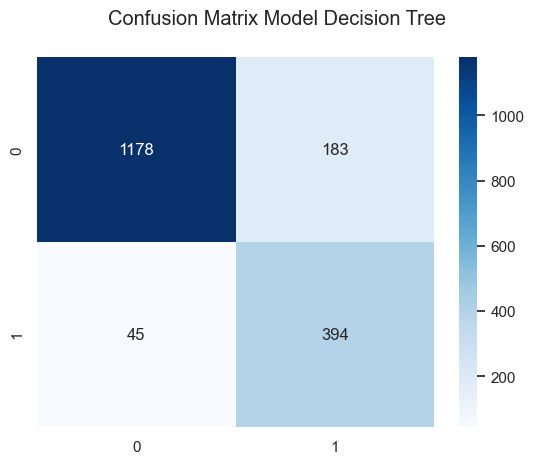

In [ ]:
cm = confusion_matrix(y_test2, train_apprx_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix Model Decision Tree")
plt.show()

In [ ]:
# Calculate ROC AUC
probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
roc_auc = roc_auc_score(y_test2, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.9064762108793782
Specificity: 0.8655400440852314
Sensitivity: 0.89749430523918


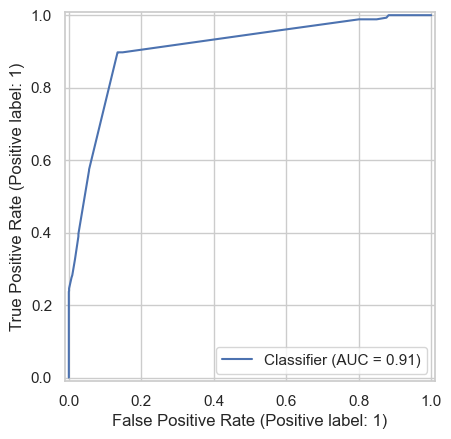

In [ ]:
RocCurveDisplay.from_predictions(y_test2, probabilities, pos_label=1)
plt.show()

In [ ]:
# roc_auc = []
# specificity = []
# sensitivity = []

# for i in range(5):
#     model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)

#     train_apprx_xgb = model_apprx_xgb.predict(x_test2)

#     # Calculate ROC AUC
#     probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
#     roc_auc = roc_auc_score(y_test2, probabilities)

#     cm = confusion_matrix(y_test2, train_apprx_xgb)
#     tn, fp, fn, tp = cm.ravel()
#     specificity = tn / (tn + fp)
#     sensitivity = tp / (tp + fn)

#     print(f"iteration{i+1}")
#     print(f"ROC_AUC{roc_auc}")
#     print(f"Specificity{specificity}")
#     print(f"Sensitivity{sensitivity}")
#     print(" ")

# Interpretasi Model

## Feature Importance

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(dt_pipeline, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_dt = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_dt[0:36]].T,
                           columns=feature_names[sorted_importances_idx_dt[0:36]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=8)

NameError: name 'dt_pipeline' is not defined

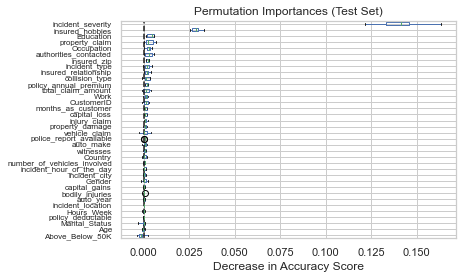

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_pipeline, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_rf = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_rf[0:36]].T,
                           columns=feature_names[sorted_importances_idx_rf[0:36]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=8)

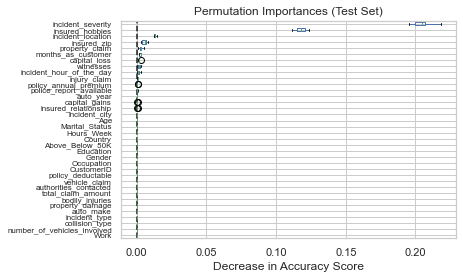

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_pipelines, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_xgb = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_xgb[0:36]].T,
                           columns=feature_names[sorted_importances_idx_xgb[0:36]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=8)

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, accuracy_score

scorer = make_scorer(accuracy_score)

result = permutation_importance(model_apprx_xgb, x_test2, y_test2, n_repeats=10, random_state=1, scoring=scorer)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx[0:36]].T,
                           columns=feature_names[sorted_importances_idx[0:36]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

## PDPs

In [ ]:
numerical_features_sorted_dt = [feature_names[i] for i in sorted_importances_idx_dt if feature_names[i] in num_col]
numerical_features_sorted_dt.reverse()

numerical_features_sorted_rf = [feature_names[i] for i in sorted_importances_idx_rf if feature_names[i] in num_col]
numerical_features_sorted_rf.reverse()

numerical_features_sorted_xgb = [feature_names[i] for i in sorted_importances_idx_xgb if feature_names[i] in num_col]
numerical_features_sorted_xgb.reverse()

# numerical_features_sorted = [feature_names[i] for i in sorted_importances_idx if feature_names[i] in num_col]
# numerical_features_sorted.reverse()

print(numerical_features_sorted_dt)
print(numerical_features_sorted_rf)
print(numerical_features_sorted_xgb)

['insured_zip', 'auto_year', 'policy_annual_premium', 'property_claim', 'witnesses', 'months_as_customer', 'total_claim_amount', 'incident_hour_of_the_day', 'policy_deductable', 'vehicle_claim', 'capital_gains', 'capital_loss', 'injury_claim', 'Hours_Week', 'CustomerID', 'Age', 'bodily_injuries', 'number_of_vehicles_involved']
['property_claim', 'insured_zip', 'policy_annual_premium', 'total_claim_amount', 'CustomerID', 'months_as_customer', 'capital_loss', 'injury_claim', 'vehicle_claim', 'witnesses', 'number_of_vehicles_involved', 'incident_hour_of_the_day', 'capital_gains', 'bodily_injuries', 'auto_year', 'Hours_Week', 'policy_deductable', 'Age']
['insured_zip', 'property_claim', 'months_as_customer', 'capital_loss', 'witnesses', 'incident_hour_of_the_day', 'injury_claim', 'policy_annual_premium', 'auto_year', 'capital_gains', 'Age', 'Hours_Week', 'CustomerID', 'policy_deductable', 'vehicle_claim', 'total_claim_amount', 'bodily_injuries', 'number_of_vehicles_involved']


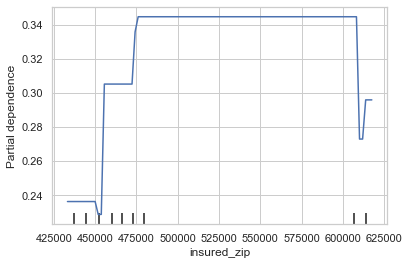

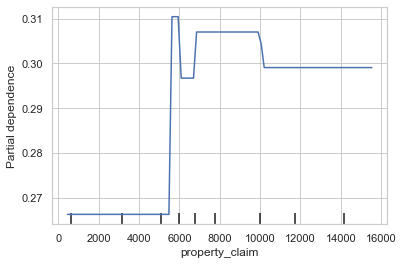

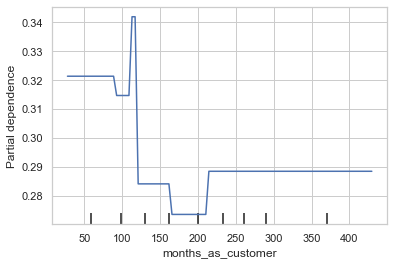

In [ ]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

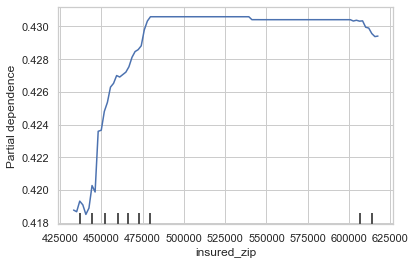

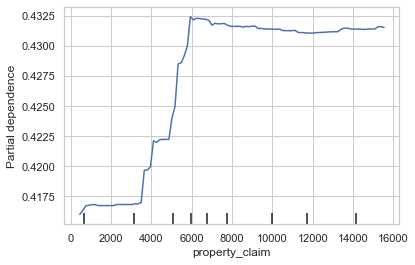

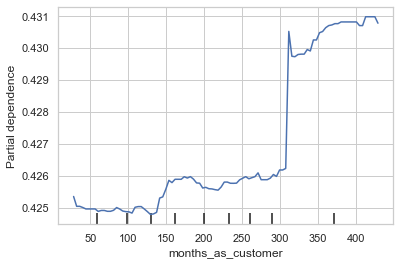

In [ ]:
PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

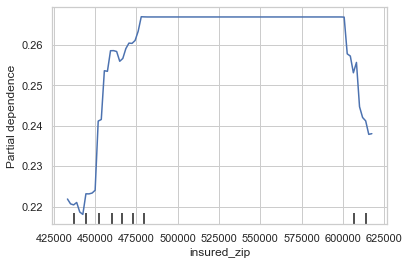

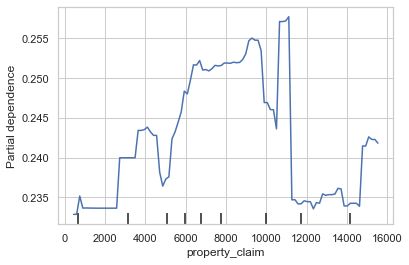

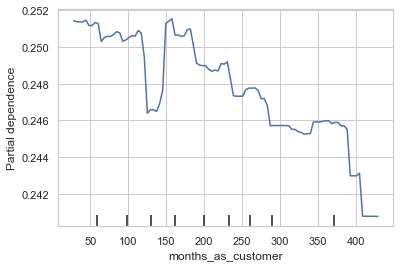

In [ ]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

## ICEs

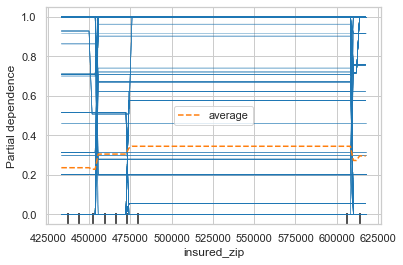

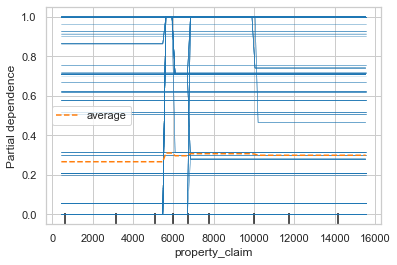

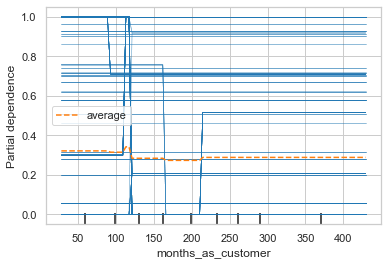

In [ ]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

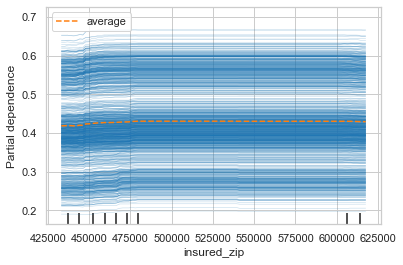

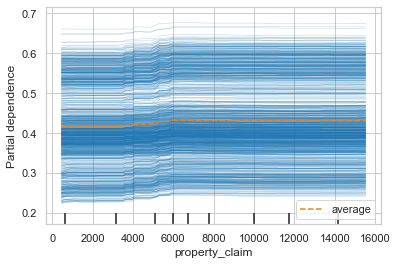

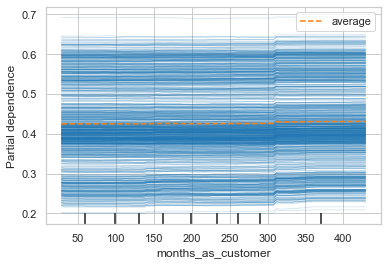

In [ ]:
PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

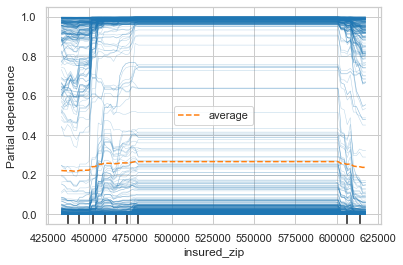

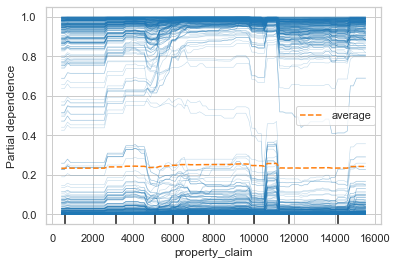

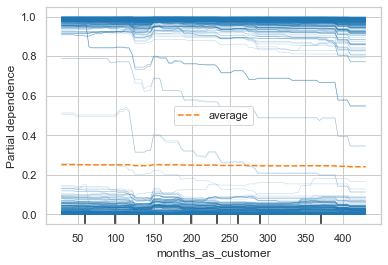

In [ ]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

# Transparent Model Interpretation

## Model Decision Tree
- Tree Rules
- Plot Tree

In [ ]:
model_dt = DecisionTreeClassifier(criterion='entropy',max_depth=9, min_samples_leaf=50, min_samples_split=50)

In [ ]:
# Show The Rule from Model

model_dt.fit(x_smote, y_smote)

rule = export_text(model_dt)
print(rule)

|--- feature_126 <= 0.30
|   |--- feature_97 <= 0.25
|   |   |--- feature_98 <= 0.21
|   |   |   |--- feature_1174 <= 0.17
|   |   |   |   |--- feature_1156 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1156 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_1174 >  0.17
|   |   |   |   |--- feature_124 <= 0.50
|   |   |   |   |   |--- feature_1168 <= 0.23
|   |   |   |   |   |   |--- feature_1167 <= 0.42
|   |   |   |   |   |   |   |--- feature_1165 <= 0.44
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_1165 >  0.44
|   |   |   |   |   |   |   |   |--- feature_1179 <= 0.53
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1179 >  0.53
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1167 >  0.42
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1168 >  0.23
|   |   |   |   |   |   |--- feature_1167 

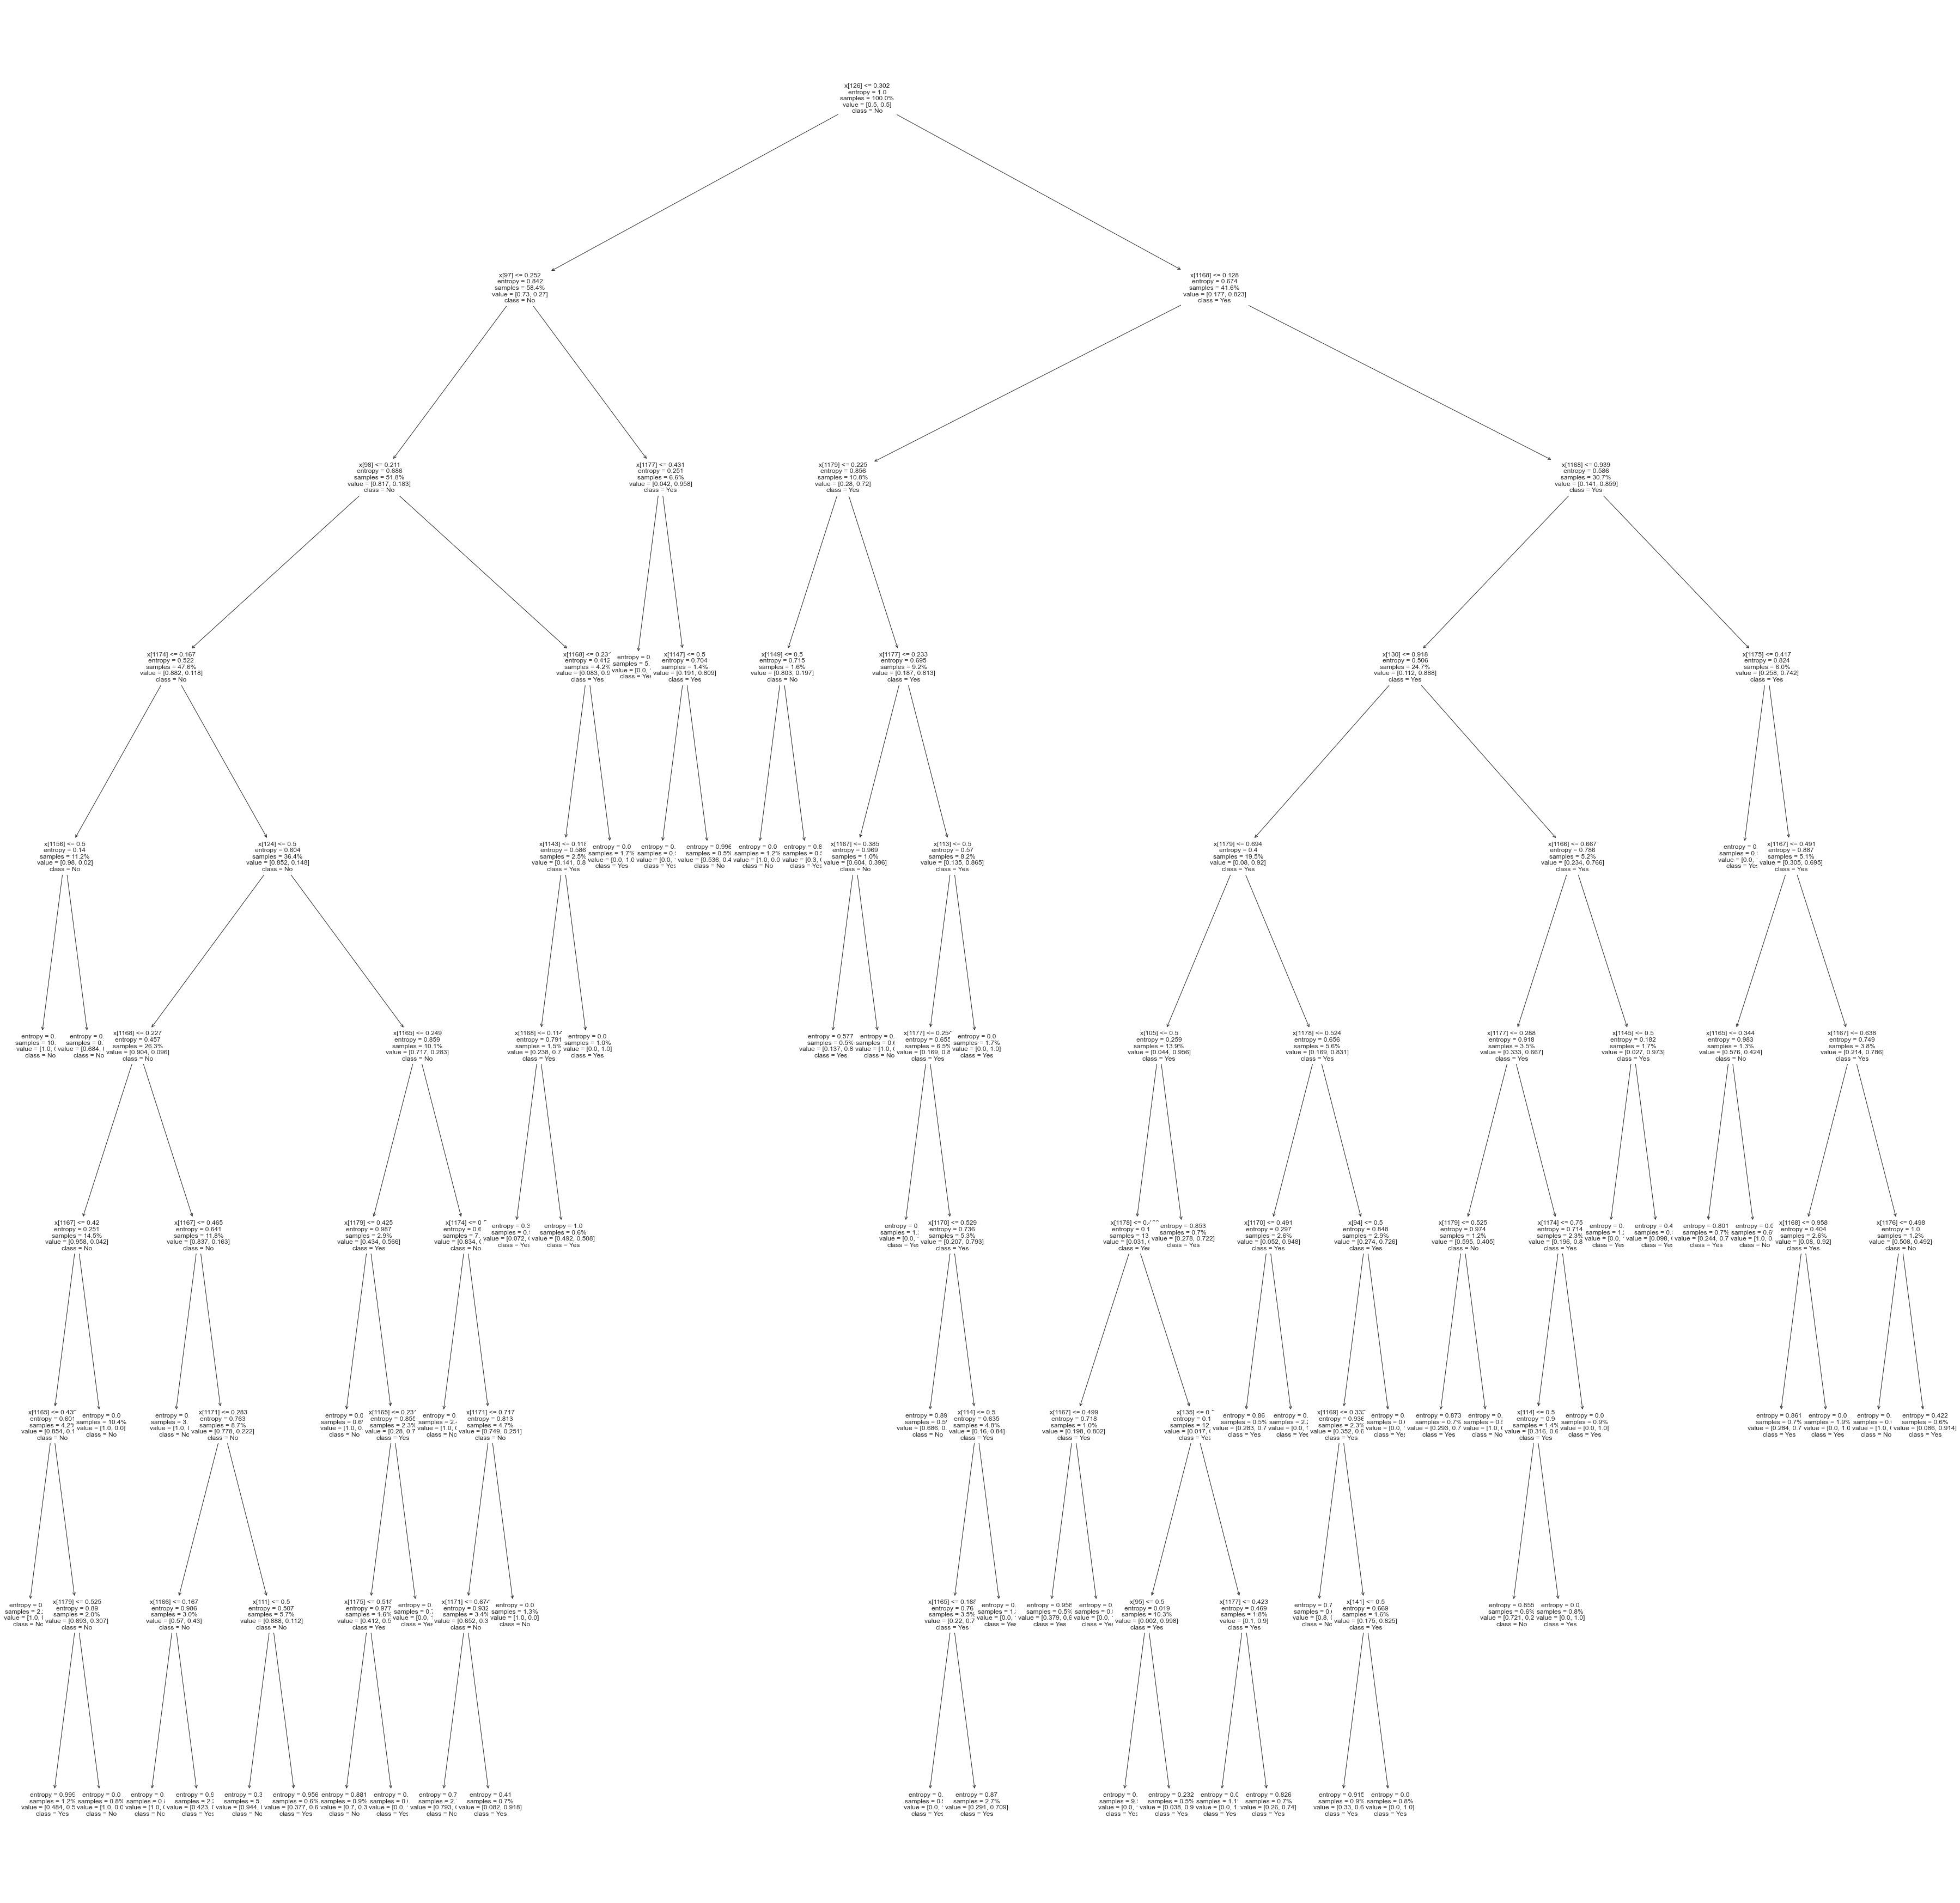

In [ ]:
plt.figure(figsize=(64,64))
plot_tree(model_dt, fontsize=12, proportion=True,class_names=['No', 'Yes'])
plt.show()

## Model Approximating XGBoost
- Tree Rules
- Decision Path

In [ ]:
model_apprx_xgb.tree.print_tree(feature_cols)

|--- incident_severity_Major Damage >= 0.604346037
|   |--- auto_make_Ford >= 0.585288405
|   |   |--- Gender_Female >= 0.441138923
|   |   |   |--- Gender_Male >= 0.854488075
|   |   |   |   |--- Education_HS-grad >= 0.0047097085
|   |   |   |   |   |--- capital_loss >= 0.800180018
|   |   |   |   |   |   |--- injury_claim >= 0.317016304
|   |   |   |   |   |   |   |--- Marital_Status_Married-civ-spouse >= 0.0874073133
|   |   |   |   |   |   |   |   |--- Below_50K >= 0.996602833
|   |   |   |   |   |   |   |   |   |--- months_as_customer >= 0.427974939
|   |   |   |   |   |   |   |   |   |   |--- Class: 1
|   |   |   |   |   |   |   |   |   |--- months_as_customer < 0.427974939
|   |   |   |   |   |   |   |   |   |   |--- Class: 1
|   |   |   |   |   |   |   |   |--- Below_50K < 0.996602833
|   |   |   |   |   |   |   |   |   |--- collision_type_Rear Collision >= 0.0844159797
|   |   |   |   |   |   |   |   |   |   |--- Class: 1
|   |   |   |   |   |   |   |   |   |--- collision_type

In [ ]:
# Get the decision paths for the input data
paths = model_apprx_xgb.get_decision_paths(df)

# Print the decision paths
for i, path in enumerate(paths, start=1):
    print(f"Path {i}: {' -> '.join(path)}")

In [ ]:
extractNodesFromModel(model_xgb)